# Import data and initial specification 

## import data

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from pathlib import Path

today = datetime.now().strftime('%Y-%m-%d')
share_path= Path('/Users/valler/Python/OX_Thesis/OX_thesis/Data/SHARE')

# import data
data=pd.read_pickle(share_path/'harmonised/H_SHARE_f.pkl')
print('we have imported the data and it has {} rows and {} columns'.format(data.shape[1],data.shape[0]))

we have imported the data and it has 6385 rows and 139620 columns


In [2]:
latest_wave = '8'
drink_wave=[2,4,5]
financial_difficulties_wave=[3,7]
today = datetime.now().strftime('%Y-%m-%d')

## Data recode record initiation

In [3]:
import os 


if os.path.exists(share_path/'recoded_data.pkl'):
    df_recode_record=pd.read_csv(share_path/'recode_record.csv')
    df = pd.read_pickle(share_path/'recoded_data.pkl')
    print(f'we have recoded {len(df_recode_record)} vars so far, keep going on')
    print(f"and the last variable is {df_recode_record.loc[len(df_recode_record)-1,'varname']}")
    
else:
    columns = ['varname',
               'conventional_name',
               'varname_in_raw',
               'domain',

               'available_waves',  # 0:time invariant
               'recode_type', # [historical, multi-response, direct]
               'reverse_code', # Boolean
               'maximum_missing_response', # If the variable 
               'replace_dict',
               'standardise',

               'notes',
               'in_HRS',
               'in_ELSA',
               'recode_date']
    
    df_recode_record=pd.DataFrame(columns=columns)


we have recoded 33 vars so far, keep going on
and the last variable is Zperceivedconstraints


In [4]:
def add_row_to_df_record(new_row,df_recode_record):
    """
    add row to df_recode_record
    if the row exists, rewrite it
    """
    varname= new_row['varname']
    replace_control = 1 # by deafualt, we update the dict
    
    if varname in list(df_recode_record['varname']):
        exist_row=df_recode_record.loc[df_recode_record['varname']==varname,:]
        
        # for vars with replace_dict, ask whether to clean it 
        replace_dict=exist_row['replace_dict'].values[0]
        if not pd.isnull(replace_dict) and isinstance(replace_dict,dict):
            
            
            stay_control=True
            while stay_control:
                print('we have found the dict as follows')
                for key in replace_dict.keys():
                    print('{}->{}'.format(key,replace_dict[key]))
                    
                replace_control=input("do you want to update it? 1->yes 0->no")
                try:
                    replace_control=int(replace_control)
                    if replace_control in [1,0]:
                        stay_control=False
                    else:   
                        print('please check your response and try again')
                except:
                    print('please check your response and try again')
            
            
        
        # only keep those rows that doesn't match the new varname
        df_recode_record=df_recode_record.where(df_recode_record['varname']!=varname)
        df_recode_record.dropna(how='all',inplace=True)
    
    if  replace_control==0:  # not update, keep the original one
        print('we will keep the original replace_dict')
        new_row['replace_dict']=replace_dict
        
    df_recode_record=df_recode_record.append(new_row,ignore_index=True)
    
         
    return df_recode_record


## Functions 


### basic functions


In [5]:
def gen_data_across_waves(varname_w1,total_waves,data):
    """
    generate the column names with the first column name
    when we need to draw information from multiple waves
    """
    var_names=[]
    for i in range(1,total_waves+1):
        var_names.append(varname_w1.replace('1',str(i)))
    temp = data[var_names]
    return temp

def count_times(df_row,response_to_count):
    """
    send the row and response to count, to count the times that the 
    response has appeared in ech row/ppl
    e.g. df['rentperiod'] = temp.apply(count_times,axis=1,response_to_count='1.own home')
    """
    count=0
    for item in df_row:
        if item==response_to_count:
            count+=1
    return count


def average_response_by_row(df_row,maximum_missing_response):
    """
    for vars that draw info from multiple variables, this
    function help to average them with maximum_missing_response
    # df_row should be sliced data
    """
    
    missing_count=sum(pd.isnull(df_row))
    if missing_count>=maximum_missing_response:
        return None
    else:
        df_row=[x for x in df_row if not pd.isnull(x)]
        # average among avaliable responses
        return sum(df_row)/len(df_row)



### multiple response functions


In [6]:

def multiresponse_average(varname,df_recode_record,data,df,print_missing_count_control):
    """
    automation of average to multiple response
    """
    
    sliced_row = df_recode_record.loc[df_recode_record['varname']==varname,]
    varset=sliced_row['var_set'].values[0]
    maximum_missing_response=sliced_row['maximum_missing_response'].values[0]
    reverse_control=sliced_row['reverse_code'].values[0]
    
    sliced_data = data[varset].copy()
    
    # print_missing counts info
    if print_missing_count_control:
        missing_count(sliced_data)
    
    print(f'1. maximum_missing_response {maximum_missing_response}\n2. reverse_control {reverse_control}')
    
    # replace string to number 
    replace_dict=replace_response_with_value(sliced_data)
    print("3. the replace dict is {}".format(replace_dict))
    sliced_data.replace(replace_dict,inplace=True)
    
    # reverse control
    if reverse_control:
        
        unique_vals = get_unique_valaues(sliced_data)
        print("4. unique_vals are {}".format(unique_vals))
        replace_dict = generate_value_replace_dict(unique_vals)
        print("5. dict is {}".format(replace_dict))
        sliced_data.replace(replace_dict,inplace=True)
    
    # if there is only one variable, set it to the df directly rather than averaging them 
    if len(varset)==1:
        df[varname]=sliced_data[varset[0]]
    else:    
        df[varname]=sliced_data.apply(average_response_by_row,axis=1,maximum_missing_response=maximum_missing_response)
    
    return df

def generate_value_replace_dict(res_lst):
    """
    return the replace dict for reverse coding 
    """
    replace_dict={}
    max_val=max(res_lst)
    res_lst.sort()
    res_len=len(res_lst)
    
    for index in range(res_len):
        reverse_ind = res_len-index-1
        replace_dict[res_lst[index]]=res_lst[reverse_ind]
    return replace_dict  

def get_unique_valaues(sliced_data):
    """
    if we need to treat values from all columns as a whole,
    this function help to get the unique value list
    """
    unique_list=[]
    for column in sliced_data.columns:
        unique_list+=list(sliced_data[column].unique())
    
    # delete repeat value
    unique_list=list(set(unique_list))
    
    # get rid of nans
    unique_list= [x for x in unique_list if not pd.isnull(x)]
    return unique_list


def replace_response_with_value(sliced_data):
    """
    replace the string response with numbers 
    # here by default we assume all the values are format of '#. explain'
    # e.g. '1.hardly ever or never'
    """
    replace_dict={}
    response_list = get_unique_valaues(sliced_data)
    
    # generate the dict
    for res in response_list:
        if isinstance(res,str):
            number=res.split('.')[0]
            replace_dict[res]=int(number)
        elif isinstance(res,float) or isinstance(res,int):
            number=res
            replace_dict[res]=int(number)
        else:
            print('the response is incorrect, {}, type{}'.format(res,type(res)))
        
        
    return replace_dict

def missing_count(sliced_data):
    """
    print the missing counts in each row, account for all columns in var_set
    """
    
    def return_sum_of_null(row):
        missing_count=sum(pd.isnull(row))
        return missing_count
    sliced_data['missing_count']=sliced_data.apply(return_sum_of_null,axis=1)
    print("0. missing information -------- start")
    print(sliced_data['missing_count'].value_counts())
    sliced_data.drop(columns=['missing_count'],inplace=True)
    
    

### historical response functions 

- historical response : mainly for yes or no type variable
- once `yes` lable appears, it will be counted as `yes`  

In [7]:

def historical_response_recorder(varname,df_recode_record,data,df):
    """
    check whether there is any affimative response to the question, if exists (doesn't matter how many times) ->1
    """
    
    sliced_row = df_recode_record.loc[df_recode_record['varname']==varname,]
    varset = sliced_row['var_set'].values[0]
    sliced_data = data[varset].copy()

    # get the replace_dict by inputting or from df_recode_record
        
    replace_dict=generate_replace_dict_for_historical_response(sliced_row,sliced_data)
    replace_dict['nan']=None
    # record the replace_dict
    
    df_recode_record.loc[df_recode_record['varname']==varname,'replace_dict']=[replace_dict]
    
    # here all the values will be changed to 1/-1 value
    # first convert all columns to str (could be categorical)
    # for col in sliced_data.columns:
        # sliced_data[col].replace(replace_dict,inplace=True)
        # sliced_data[col]=sliced_data[col].astype('str')
        
    # print(f'unique values are {get_unique_valaues(sliced_data)}')
    # print(sliced_data.value_counts())
    print(f'\n1.the replace dict is \n{replace_dict}')
    
    sliced_data.replace(replace_dict,inplace=True)
    
    
    # if there is only one variable being sent -> set the sliced_data to df directly
    if len(varset)==1:
        
        df[varname]=sliced_data[varset[0]]
    else:
        # mark response 
        df[varname]=sliced_data.apply(mark_positive_response,axis=1)
        
    return df,df_recode_record


def generate_replace_dict_for_historical_response(sliced_row,sliced_data):
    """
    generate the replace_dict if there is nothing in sliced_row['replace_dict']/returned object is not dict
    """
    
    try:
        replace_dict=sliced_row['replace_dict'].values[0]
    except:
        replace_dict=None
    # if we had done it, we shouldn't do it again..
    if pd.isnull(replace_dict) or not isinstance(replace_dict,dict):
        replace_dict={}
        response_list = get_unique_valaues(sliced_data)
        print(f'all responses are: {response_list}')
        for response in response_list:
            Pass_control=True
            while Pass_control:
                replace_val=input(f'replace response [{response}] with int .. (999 -> none)')
                try:
                    replace_val=int(replace_val)
                    Pass_control=False
                except:
                    print('error in the response, please try again')
                    
            replace_dict[response]= None if replace_val==999 else replace_val 
            
    return replace_dict
    
def mark_positive_response(df_row):
    """
    if 1 exists in df_row, mark it as 1 else -1
    """
    if 1 in list(df_row):
        return 1
    else:
        return -1

### replace only function

In [8]:
def replace_only_recorder(varname,df_recode_record,data,df):
    
    # get the records 
    sliced_row = df_recode_record.loc[df_recode_record['varname']==varname,]
    varset=sliced_row['var_set'].values[0]
    reverse_control = sliced_row['reverse_code'].values[0]
    sliced_data = data[varset].copy()
    

    # get the replace_dict by inputting or from df_recode_record
    replace_dict=generate_replace_dict_for_historical_response(sliced_row,sliced_data)
    replace_dict['nan']=None
    # record the replace_dict
    
    
    df_recode_record.loc[df_recode_record['varname']==varname,'replace_dict'] = [replace_dict]
    print(f'\n1.the replace dict is \n{replace_dict}')
    
    df[varname] = sliced_data.replace(replace_dict)
    
    # we reverse code lastly to avoid crashing the previous replacing action
    if reverse_control:
        response_list = list(replace_dict.values())
        while None in response_list: response_list.remove(None)
        reverse_replace_dict = generate_value_replace_dict(response_list)
        df[varname].replace(reverse_replace_dict, inplace=True)
    
    return df,df_recode_record
    

## Recode Processor 

after reading the new_row dict, decide which function we should use 

In [9]:
def recode_processor(varname,df_recode_record,df):
    var_dict=df_recode_record.loc[df_recode_record['varname']==varname,:].to_dict('records')[0]

    if var_dict['recode_type']=='direct_use':
        df[varname]=data[var_dict['var_set']]
        print(df[varname].describe())
    elif var_dict['recode_type']=='replace_only':
        df,df_recode_record = replace_only_recorder(varname,df_recode_record,data,df)
        print(f'\n2. the updated var_dict is\n{var_dict}')
        print(f'\n3. statistics\n{df[varname].value_counts()}')
    elif var_dict['recode_type']=='historical':
        df,df_recode_record=historical_response_recorder(varname,df_recode_record,data,df)
        print(df[varname].value_counts())
    elif var_dict['recode_type'] == 'multi_response':
        print_missing_count_control=True if input('want to check the missings ? 1/0 ')=='1' else False
        df=multiresponse_average(varname,df_recode_record,data,df,print_missing_count_control)
    return df,df_recode_record

## New Var Recorder

In [10]:
domain_dict={"1":"Demographic", "2": "Childhood Adversity",
             "3": "Adulthood Socioeconomic","4":"Adulthood Health Behaviors",
             "5":"Adulthood Social Connections","6":"Adulthood Psychological",
             "7":"Adulthood Adverse Experiences","8":'Others'}

recode_type_dict={"1":'historical',"2":'multi_response',"3":'replace_only',"4":'direct_use',"5":'row_manual'}

wave_controller_dict={"1":'latest_wave',"2":"single_wave",'3':"drink_wave",'4':'financial_difficulties_wave',"5":"manual"}

def new_var_record_input(varname,var_set,available_waves,replace_dict,notes):
    new_row={}
    
    new_row['varname']=varname
    new_row['var_set']=var_set
    new_row['available_waves'] = available_waves
    new_row['replace_dict'] =replace_dict
    new_row['notes'] = notes

    new_row['conventional_name']=input("what's the conventional name? ")
    
    for key,value in domain_dict.items():
        print(f'\n{key}:{value}')
    domain_key=input("what's the domain? (select the number) ")
    new_row['domain']=domain_dict[domain_key]
        
    for key,value in recode_type_dict.items():
        print(f'\n{key}:{value}')
    recode_type_key=input("what's the recode_type? ")
    new_row['recode_type']=recode_type_dict[recode_type_key]
    
    for key,value in wave_controller_dict.items():
        print(f'\n{key}:{value}')
    wave_controller_key=input("what's the recode_type? ")
    new_row['wave_controller']=wave_controller_dict[wave_controller_key]
    
    reverse_code_control = input('do this var need to be reverse_coded? 1/0 ')
    new_row['reverse_code']=True if reverse_code_control=='1' else False

    
    new_row['maximum_missing_response']=int(input("what's the maximum_missing_response? ")) if recode_type_key=='2' else None
    
    standardise_control = input('do this var need to be standardised? 1/0 ')
    new_row['standardise']=True if standardise_control=='1' else False
    
    HRS_control= input('Is this var in HRS? 1/0 ')
    new_row['in_HRS']=True if HRS_control=='1' else False
    
    ELSA_control= input('Is this var in ELSA? 1/0 ')
    new_row['in_ELSA']=True if ELSA_control=='1' else False
    
    new_row['recode_date']=today
    
    return new_row
    

# IDs and Death Info 

## Weights

## Identifiers

In [10]:
df=pd.DataFrame()
df[['hhid','pn','mergeid','isocountry']]=data[['hhid','pn','mergeid','isocountry']]

## Death Year `deathY`

In [201]:
varname='deathY'
var_set=['radyear']

new_row={'varname': varname,
 'var_set': var_set,
 'available_waves': [0],
 'replace_dict': None,
 'notes': None,
 'conventional_name': 'Death Year',
 'domain': 'Others',
 'recode_type': 'direct_use',
 'wave_controller': 'single_wave',
 'reverse_code': False,
 'maximum_missing_response': None,
 'standardise': False,
 'in_HRS': True,
 'in_ELSA': True,
 'recode_date': '2023-01-10'}
df_recode_record=add_row_to_df_record(new_row,df_recode_record)

varname='deathY'
var_set=['radyear']
available_waves= [0]
replace_dict=  None
notes=None 


new_row=new_var_record_input(varname,var_set,available_waves,replace_dict,notes)
df_recode_record=add_row_to_df_record(new_row,df_recode_record)
new_row

In [101]:
varname='deathY'
df,df_recode_record=recode_processor(varname,df_recode_record,df)

<AxesSubplot:>

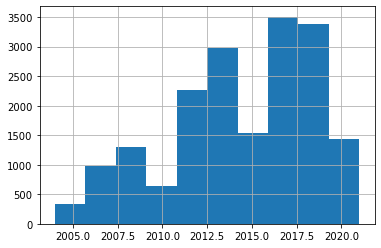

In [3]:
df['deathY'].hist()

In [13]:
df['deathY'].value_counts()

2016.0    1910
2018.0    1718
2019.0    1668
2017.0    1597
2014.0    1586
2015.0    1538
2013.0    1391
2012.0    1357
2020.0     922
2011.0     901
2008.0     723
2010.0     644
2009.0     571
2007.0     527
2021.0     512
2006.0     446
2005.0     290
2004.0      48
Name: deathY, dtype: int64

In [72]:
len(df)

139620

In [15]:
sum(df['deathY'].value_counts())

18349

# Demographics 

## Age at Interview `age`

In [203]:
varname='age'
var_set=['r8agey'.replace('8',latest_wave)]

new_row={'varname': varname,
 'var_set': var_set,
 'available_waves': [1, 2, 3, 4, 5, 6, 7, 8],
 'replace_dict': None,
 'notes': None,
 'conventional_name': 'Age at Interview',
 'wave_controller': 'latest_wave',
 'domain': 'Demographic',
 'recode_type': 'direct_use',
 'reverse_code': False,
 'maximum_missing_response': None,
 'standardise': True,
 'in_HRS': True,
 'in_ELSA': True,
 'recode_date': '2023-01-10'}

df_recode_record=add_row_to_df_record(new_row,df_recode_record)


varname='age'
var_set=['r8agey'.replace('8',latest_wave)]
available_waves= list(range(1,9))
replace_dict=  None
notes=None 


new_row=new_var_record_input(varname,var_set,available_waves,replace_dict,notes)
df_recode_record=add_row_to_df_record(new_row,df_recode_record)
new_row

In [21]:
varname='age'
df,df_recode_record=recode_processor(varname,df_recode_record,df)
df[varname].describe()

count    46733.000000
mean        70.270815
std          9.472927
min         31.000000
25%         63.000000
50%         70.000000
75%         77.000000
max        103.000000
Name: age, dtype: float64

## Male `maleYN`

In [200]:
varname='maleYN'
var_set=['ragender']

new_row={'varname':varname,
 'var_set': var_set,
 'available_waves': [0],
 'replace_dict': {'1.man': 1, '2.woman': -1, 'nan': None},
 'notes': None,
 'conventional_name': 'Male',
 'domain': 'Demographic',
 'recode_type': 'replace_only',
 'wave_controller': 'single_wave',
 'reverse_code': False,
 'maximum_missing_response': None,
 'in_HRS':True,
 'in_ELSA': True,
 'standardise': True,
 'recode_date': '2023-01-10'}
df_recode_record=add_row_to_df_record(new_row,df_recode_record)


we have found the dict as follows
1.man->1
2.woman->-1
nan->None
do you want to update it? 1->yes 0->no0
we will keep the original replace_dict


,varname,conventional_name,varname_in_raw,domain,available_waves,recode_type,reverse_code,maximum_missing_response,replace_dict,standardise,notes,recode_date,var_set,in_ELSA,in_HRS,wave_controller
0,deathY,Death Year,NaN,Others,[0],direct_use,False,None,None,False,None,2023-01-10,[radyear],True,True,NaN
1,age,Age at Interview,NaN,Demographic,"[1, 2, 3, 4, 5, 6, 7, 8]",direct_use,False,None,None,True,None,2023-01-10,[r8agey],True,True,NaN
2,everunemployed,History of Unemployment,NaN,Adulthood Socioeconomic,"[1, 2, 3, 4, 5, 6, 7, 8]",historical,False,None,None,True,None,2023-01-10,"[r1unemp, r2unemp, r3unemp, r4unemp, r5unemp, ...",True,True,latest_wave
3,lencurmarridge,length of current marriage,NaN,Adulthood Socioeconomic,"[1, 2, 3, 4, 5, 6, 7, 8]",direct_use,False,None,None,True,None,2023-01-10,[r1mcurln],False,False,latest_wave
4,currentpaternered,Current Marital Status: With Partnership,NaN,Adulthood Socioeconomic,"[1, 2, 3, 4, 5, 6, 7, 8]",replace_only,False,None,None,True,None,2023-01-10,[r8mstat],True,False,latest_wave
5,Zeduccat,Lower Education,NaN,Adulthood Socioeconomic,[0],replace_only,True,None,"{'1.Primary education': 1, '3.Upper secondary ...",True,"not same as HRS, we use the ISCED 2 code for e...",2023-01-10,[raedisced],True,True,latest_wave
6,rural,Residence in Rurual,NaN,Demographic,"[1, 2, 3, 4, 5, 6, 7, 8]",replace_only,False,None,"{'1.rural': 1, '0.urban': -1, 'nan': None}",True,1:rural;-1:urban,2023-01-10,[h8rural],False,False,latest_wave
7,citizenship,Citizenship Status,NaN,Demographic,[0],replace_only,False,None,"{'0.No': -1, '1.Yes': 1, 'nan': None}",True,whether citizen at baseline interview,2023-01-10,[racitizen],False,False,single_wave
8,migrantYN,Foreign Born,NaN,Demographic,[0],replace_only,False,None,"{'1.in country': -1, '0.out of country': 1, 'n...",True,Born in Country of Interview,2023-01-10,[rabcountry],True,True,single_wave
9,maleYN,Male,NaN,Demographic,[0],replace_only,False,None,"{'1.man': 1, '2.woman': -1, 'nan': None}",True,None,2023-01-10,[ragender],True,True,single_wave


varname='maleYN'
var_set=['ragender']
available_waves= [0]
replace_dict=  None
notes=None 


new_row=new_var_record_input(varname,var_set,available_waves,replace_dict,notes)
df_recode_record=add_row_to_df_record(new_row,df_recode_record)
new_row

In [44]:
varname='maleYN'
df,df_recode_record=recode_processor(varname,df_recode_record,df)


1.the replace dict is 
{'1.man': 1, '2.woman': -1, 'nan': None}

2. the updated var_dict is
 {'varname': 'maleYN', 'conventional_name': 'Male', 'varname_in_raw': nan, 'domain': 'Demographic', 'available_waves': [0], 'recode_type': 'replace_only', 'reverse_code': False, 'maximum_missing_response': None, 'replace_dict': {'1.man': 1, '2.woman': -1, 'nan': None}, 'standardise': True, 'notes': None, 'recode_date': '2023-01-10', 'var_set': ['ragender']}

3. statistics
 -1    77707
 1    61913
Name: maleYN, dtype: int64


## Foreign Born `migrantYN`

In [199]:
varname='migrantYN'
var_set=['rabcountry']

new_row={'varname': varname,
 'var_set': var_set,
 'available_waves': [0],
 'replace_dict': {'1.in country': -1, 
                  '0.out of country': 1, 
                  'nan': None},
 'notes': 'Born in Country of Interview',
 'conventional_name': 'Foreign Born',
 'domain': 'Demographic',
 'wave_controller': 'single_wave',
 'recode_type': 'replace_only',
 'reverse_code': False,
 'maximum_missing_response': None,
 'standardise': True,
 'in_HRS': True,
 'in_ELSA': True,
 'recode_date': '2023-01-10'}

df_recode_record=add_row_to_df_record(new_row,df_recode_record)


we have found the dict as follows
1.in country->-1
0.out of country->1
nan->None
do you want to update it? 1->yes 0->no0
we will keep the original replace_dict


,varname,conventional_name,varname_in_raw,domain,available_waves,recode_type,reverse_code,maximum_missing_response,replace_dict,standardise,notes,recode_date,var_set,in_ELSA,in_HRS,wave_controller
0,deathY,Death Year,NaN,Others,[0],direct_use,False,None,None,False,None,2023-01-10,[radyear],True,True,NaN
1,age,Age at Interview,NaN,Demographic,"[1, 2, 3, 4, 5, 6, 7, 8]",direct_use,False,None,None,True,None,2023-01-10,[r8agey],True,True,NaN
2,maleYN,Male,NaN,Demographic,[0],replace_only,False,None,"{'1.man': 1, '2.woman': -1, 'nan': None}",True,None,2023-01-10,[ragender],True,True,NaN
3,everunemployed,History of Unemployment,NaN,Adulthood Socioeconomic,"[1, 2, 3, 4, 5, 6, 7, 8]",historical,False,None,None,True,None,2023-01-10,"[r1unemp, r2unemp, r3unemp, r4unemp, r5unemp, ...",True,True,latest_wave
4,lencurmarridge,length of current marriage,NaN,Adulthood Socioeconomic,"[1, 2, 3, 4, 5, 6, 7, 8]",direct_use,False,None,None,True,None,2023-01-10,[r1mcurln],False,False,latest_wave
5,currentpaternered,Current Marital Status: With Partnership,NaN,Adulthood Socioeconomic,"[1, 2, 3, 4, 5, 6, 7, 8]",replace_only,False,None,None,True,None,2023-01-10,[r8mstat],True,False,latest_wave
6,Zeduccat,Lower Education,NaN,Adulthood Socioeconomic,[0],replace_only,True,None,"{'1.Primary education': 1, '3.Upper secondary ...",True,"not same as HRS, we use the ISCED 2 code for e...",2023-01-10,[raedisced],True,True,latest_wave
7,rural,Residence in Rurual,NaN,Demographic,"[1, 2, 3, 4, 5, 6, 7, 8]",replace_only,False,None,"{'1.rural': 1, '0.urban': -1, 'nan': None}",True,1:rural;-1:urban,2023-01-10,[h8rural],False,False,latest_wave
8,citizenship,Citizenship Status,NaN,Demographic,[0],replace_only,False,None,"{'0.No': -1, '1.Yes': 1, 'nan': None}",True,whether citizen at baseline interview,2023-01-10,[racitizen],False,False,single_wave
9,migrantYN,Foreign Born,NaN,Demographic,[0],replace_only,False,None,"{'1.in country': -1, '0.out of country': 1, 'n...",True,Born in Country of Interview,2023-01-10,[rabcountry],True,True,single_wave


varname='migrantYN'
var_set=['rabcountry']
available_waves= [0]
replace_dict=  None
notes='Born in Country of Interview' 


new_row=new_var_record_input(varname,var_set,available_waves,replace_dict,notes)
df_recode_record=add_row_to_df_record(new_row,df_recode_record)
new_row

In [112]:
varname='migrantYN'
df,df_recode_record=recode_processor(varname,df_recode_record,df)

replace response [1.in country] with int .. (999 -> none)-1
replace response [0.out of country] with int .. (999 -> none)1

1.the replace dict is 
{'1.in country': -1, '0.out of country': 1, 'nan': None}

2. the updated var_dict is
{'varname': 'migrantYN', 'conventional_name': 'Foreign Born', 'varname_in_raw': nan, 'domain': 'Demographic', 'available_waves': [0], 'recode_type': 'replace_only', 'reverse_code': False, 'maximum_missing_response': None, 'replace_dict': None, 'standardise': True, 'notes': 'Born in Country of Interview', 'recode_date': '2023-01-10', 'var_set': ['rabcountry'], 'in_ELSA': True, 'in_HRS': True}

3. statistics
-1.0    124238
 1.0     14485
Name: migrantYN, dtype: int64


## Citizenship Status `citizenship`

In [198]:
varname='citizenship'
var_set=['racitizen']
new_row={'varname': varname,
 'var_set': var_set,
 'available_waves': [0],
 'replace_dict': {'0.No': -1, '1.Yes': 1, 'nan': None},
 'notes': 'whether citizen at baseline interview',
 'conventional_name': 'Citizenship Status',
 'domain': 'Demographic',
 'wave_controller': 'single_wave',
 'recode_type': 'replace_only',
 'reverse_code': False,
 'maximum_missing_response': None,
 'standardise': True,
 'in_HRS': False,
 'in_ELSA': False,
 'recode_date': '2023-01-10'}
df_recode_record=add_row_to_df_record(new_row,df_recode_record)


we have found the dict as follows
0.No->-1
1.Yes->1
nan->None
do you want to update it? 1->yes 0->no0
we will keep the original replace_dict


,varname,conventional_name,varname_in_raw,domain,available_waves,recode_type,reverse_code,maximum_missing_response,replace_dict,standardise,notes,recode_date,var_set,in_ELSA,in_HRS,wave_controller
0,deathY,Death Year,NaN,Others,[0],direct_use,False,None,None,False,None,2023-01-10,[radyear],True,True,NaN
1,age,Age at Interview,NaN,Demographic,"[1, 2, 3, 4, 5, 6, 7, 8]",direct_use,False,None,None,True,None,2023-01-10,[r8agey],True,True,NaN
2,maleYN,Male,NaN,Demographic,[0],replace_only,False,None,"{'1.man': 1, '2.woman': -1, 'nan': None}",True,None,2023-01-10,[ragender],True,True,NaN
3,migrantYN,Foreign Born,NaN,Demographic,[0],replace_only,False,None,"{'1.in country': -1, '0.out of country': 1, 'n...",True,Born in Country of Interview,2023-01-10,[rabcountry],True,True,NaN
4,everunemployed,History of Unemployment,NaN,Adulthood Socioeconomic,"[1, 2, 3, 4, 5, 6, 7, 8]",historical,False,None,None,True,None,2023-01-10,"[r1unemp, r2unemp, r3unemp, r4unemp, r5unemp, ...",True,True,latest_wave
5,lencurmarridge,length of current marriage,NaN,Adulthood Socioeconomic,"[1, 2, 3, 4, 5, 6, 7, 8]",direct_use,False,None,None,True,None,2023-01-10,[r1mcurln],False,False,latest_wave
6,currentpaternered,Current Marital Status: With Partnership,NaN,Adulthood Socioeconomic,"[1, 2, 3, 4, 5, 6, 7, 8]",replace_only,False,None,None,True,None,2023-01-10,[r8mstat],True,False,latest_wave
7,Zeduccat,Lower Education,NaN,Adulthood Socioeconomic,[0],replace_only,True,None,"{'1.Primary education': 1, '3.Upper secondary ...",True,"not same as HRS, we use the ISCED 2 code for e...",2023-01-10,[raedisced],True,True,latest_wave
8,rural,Residence in Rurual,NaN,Demographic,"[1, 2, 3, 4, 5, 6, 7, 8]",replace_only,False,None,"{'1.rural': 1, '0.urban': -1, 'nan': None}",True,1:rural;-1:urban,2023-01-10,[h8rural],False,False,latest_wave
9,citizenship,Citizenship Status,NaN,Demographic,[0],replace_only,False,None,"{'0.No': -1, '1.Yes': 1, 'nan': None}",True,whether citizen at baseline interview,2023-01-10,[racitizen],False,False,single_wave


varname='citizenship'
var_set=['racitizen']
available_waves= [0]
replace_dict=  None
notes='whether citizen at baseline interview' 


new_row=new_var_record_input(varname,var_set,available_waves,replace_dict,notes)
df_recode_record=add_row_to_df_record(new_row,df_recode_record)
new_row

In [115]:
varname = 'citizenship'
df,df_recode_record=recode_processor(varname,df_recode_record,df)

replace response [0.No] with int .. (999 -> none)-1
replace response [1.Yes] with int .. (999 -> none)1

1.the replace dict is 
{'0.No': -1, '1.Yes': 1, 'nan': None}

2. the updated var_dict is
{'varname': 'citizenship', 'conventional_name': 'Citizenship Status', 'varname_in_raw': nan, 'domain': 'Demographic', 'available_waves': [0], 'recode_type': 'replace_only', 'reverse_code': False, 'maximum_missing_response': None, 'replace_dict': None, 'standardise': True, 'notes': 'whether citizen at baseline interview', 'recode_date': '2023-01-10', 'var_set': ['racitizen'], 'in_ELSA': False, 'in_HRS': False}

3. statistics
 1.0    133671
-1.0      4994
Name: citizenship, dtype: int64


## Region of Residence `rural`

In [197]:
varname='rural'
var_set=['h1rural'.replace('1',latest_wave)]

new_row={'varname': varname,
 'var_set': var_set,
 'available_waves': [1, 2, 3, 4, 5, 6, 7, 8],
 'replace_dict': {'1.rural': 1, '0.urban': -1, 'nan': None},
 'notes': '1:rural;-1:urban',
 'conventional_name': 'Residence in Rurual',
 'wave_controller': 'latest_wave',
 'domain': 'Demographic',
 'recode_type': 'replace_only',
 'reverse_code': False,
 'maximum_missing_response': None,
 'standardise': True,
 'in_HRS': False,
 'in_ELSA': False,
 'recode_date': '2023-01-10'}

df_recode_record=add_row_to_df_record(new_row,df_recode_record)

we have found the dict as follows
1.rural->1
0.urban->-1
nan->None
do you want to update it? 1->yes 0->no0
we will keep the original replace_dict


,varname,conventional_name,varname_in_raw,domain,available_waves,recode_type,reverse_code,maximum_missing_response,replace_dict,standardise,notes,recode_date,var_set,in_ELSA,in_HRS,wave_controller
0,deathY,Death Year,NaN,Others,[0],direct_use,False,None,None,False,None,2023-01-10,[radyear],True,True,NaN
1,age,Age at Interview,NaN,Demographic,"[1, 2, 3, 4, 5, 6, 7, 8]",direct_use,False,None,None,True,None,2023-01-10,[r8agey],True,True,NaN
2,maleYN,Male,NaN,Demographic,[0],replace_only,False,None,"{'1.man': 1, '2.woman': -1, 'nan': None}",True,None,2023-01-10,[ragender],True,True,NaN
3,migrantYN,Foreign Born,NaN,Demographic,[0],replace_only,False,None,"{'1.in country': -1, '0.out of country': 1, 'n...",True,Born in Country of Interview,2023-01-10,[rabcountry],True,True,NaN
4,citizenship,Citizenship Status,NaN,Demographic,[0],replace_only,False,None,"{'0.No': -1, '1.Yes': 1, 'nan': None}",True,whether citizen at baseline interview,2023-01-10,[racitizen],False,False,NaN
5,everunemployed,History of Unemployment,NaN,Adulthood Socioeconomic,"[1, 2, 3, 4, 5, 6, 7, 8]",historical,False,None,None,True,None,2023-01-10,"[r1unemp, r2unemp, r3unemp, r4unemp, r5unemp, ...",True,True,latest_wave
6,lencurmarridge,length of current marriage,NaN,Adulthood Socioeconomic,"[1, 2, 3, 4, 5, 6, 7, 8]",direct_use,False,None,None,True,None,2023-01-10,[r1mcurln],False,False,latest_wave
7,currentpaternered,Current Marital Status: With Partnership,NaN,Adulthood Socioeconomic,"[1, 2, 3, 4, 5, 6, 7, 8]",replace_only,False,None,None,True,None,2023-01-10,[r8mstat],True,False,latest_wave
8,Zeduccat,Lower Education,NaN,Adulthood Socioeconomic,[0],replace_only,True,None,"{'1.Primary education': 1, '3.Upper secondary ...",True,"not same as HRS, we use the ISCED 2 code for e...",2023-01-10,[raedisced],True,True,latest_wave
9,rural,Residence in Rurual,NaN,Demographic,"[1, 2, 3, 4, 5, 6, 7, 8]",replace_only,False,None,"{'1.rural': 1, '0.urban': -1, 'nan': None}",True,1:rural;-1:urban,2023-01-10,[h8rural],False,False,latest_wave



varname='rural'
var_set=['h1rural'.replace('1',latest_wave)]
available_waves= list(range(1,9))
replace_dict=  None
notes=None 


new_row=new_var_record_input(varname,var_set,available_waves,replace_dict,notes)
df_recode_record=add_row_to_df_record(new_row,df_recode_record)
new_row


In [118]:
varname = 'rural'
df,df_recode_record=recode_processor(varname,df_recode_record,df)

replace response [1.rural] with int .. (999 -> none)1
replace response [0.urban] with int .. (999 -> none)-1

1.the replace dict is 
{'1.rural': 1, '0.urban': -1, 'nan': None}

2. the updated var_dict is
{'varname': 'rural', 'conventional_name': 'Residence in Rurual', 'varname_in_raw': nan, 'domain': 'Demographic', 'available_waves': [1, 2, 3, 4, 5, 6, 7, 8], 'recode_type': 'replace_only', 'reverse_code': False, 'maximum_missing_response': None, 'replace_dict': None, 'standardise': True, 'notes': None, 'recode_date': '2023-01-10', 'var_set': ['h8rural'], 'in_ELSA': False, 'in_HRS': False}

3. statistics
-1.0    29359
 1.0    15198
Name: rural, dtype: int64


# Adulthood Socioeconomic

## Wealth `ZwealthT`

In [180]:
varname='ZwealthT'
var_set=['h1atotb'.replace('1',latest_wave)]
new_row={'varname': varname,
 'var_set': var_set,
 'available_waves': [1, 2, 3, 4, 5, 6, 7, 8],
 'replace_dict': None,
 'notes': None,
 'conventional_name': 'Wealth',
 'domain': 'Adulthood Socioeconomic',
 'recode_type': 'direct_use',
 'wave_controller': 'latest_wave',
 'reverse_code': False,
 'maximum_missing_response': None,
 'standardise': True,
 'in_HRS': True,
 'in_ELSA': True,
 'recode_date': '2023-01-12'}

df_recode_record=add_row_to_df_record(new_row,df_recode_record)

varname='ZwealthT'
var_set=['h1atotb'.replace('1',latest_wave)]
available_waves= list(range(1,9))
replace_dict=  None
notes=None 


new_row=new_var_record_input(varname,var_set,available_waves,replace_dict,notes)
df_recode_record=add_row_to_df_record(new_row,df_recode_record)
new_row

In [131]:
varname='ZwealthT'
df,df_recode_record=recode_processor(varname,df_recode_record,df)

count    4.659400e+04
mean     3.061818e+05
std      1.481495e+06
min     -1.138827e+06
25%      3.700000e+04
50%      1.230000e+05
75%      3.270000e+05
max      2.067499e+08
Name: ZwealthT, dtype: float64


## Income `ZincomeT`

special recoded 

In [181]:
varname='ZincomeT'
var_set=['r1itearn','r1itsemp', 'r1itpena', 'r1itpubpen', 'r1itgxfr', 'r1itothr']
var_set=[x.replace('1',latest_wave) for x in var_set]

new_row={'varname': varname,
 'var_set': var_set,
 'available_waves': [ 2, 4, 5, 6, 7, 8],
 'replace_dict': None,
 'notes': '(after tax) adding together Individual Earnings, Employer Capital Income, Pension or Annuity,Public Pensions,Other Government Transfers,Other Individual Income',
 'conventional_name': 'Total Income',
 'domain': 'Adulthood Socioeconomic',
 'recode_type': 'special_code',
 'wave_controller': 'latest_wave',
 'reverse_code': False,
 'maximum_missing_response': None,
 'standardise': True,
 'in_HRS': True,
 'in_ELSA': True,
 'recode_date': '2023-01-12'}

df_recode_record=add_row_to_df_record(new_row,df_recode_record)


varname='ZincomeT'
var_set=['r1iearn, r1ipena, r1ipubpen, r1igxfr, r1iothr']
var_set=[x.replace('1',latest_wave) for x in var_set]
available_waves= list(range(1,9))
replace_dict=  None
notes=None 


new_row=new_var_record_input(varname,var_set,available_waves,replace_dict,notes)
df_recode_record=add_row_to_df_record(new_row,df_recode_record)
new_row

In [174]:
varname='ZincomeT'
var_dict=df_recode_record.loc[df_recode_record['varname']==varname,:].to_dict('records')[0]

var_set=var_dict['var_set']
temp = data[var_set].fillna(0)
df[varname]=temp.apply(sum,axis=1)
df[varname].describe()

count    1.396200e+05
mean     5.082528e+03
std      2.184080e+04
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      4.236578e+03
max      5.889591e+06
Name: ZincomeT, dtype: float64

## Total Household Income (Respondent & Spouse) `HIncome`

In [182]:
varname='HIncome'
var_set=['h2ittot'.replace('2',latest_wave)]


new_row={'varname': varname,
 'var_set': var_set,
 'available_waves': [2, 4, 5, 6, 7, 8],
 'replace_dict': None,
 'notes': None,
 'conventional_name': 'Total Household Income',
 'domain': 'Adulthood Socioeconomic',
 'recode_type': 'direct_use',
 'wave_controller': 'latest_wave',
 'reverse_code': False,
 'maximum_missing_response': None,
 'standardise': True,
 'in_HRS': False,
 'in_ELSA': False,
 'recode_date': '2023-01-12'}

df_recode_record=add_row_to_df_record(new_row,df_recode_record)

varname='HIncome'
var_set=['h2ittot'.replace('2',latest_wave)]

available_waves= [2,4,5,6,7,8]
replace_dict=  None
notes=None 


new_row=new_var_record_input(varname,var_set,available_waves,replace_dict,notes)
df_recode_record=add_row_to_df_record(new_row,df_recode_record)
new_row

In [177]:
varname='HIncome'
df,df_recode_record = recode_processor(varname,df_recode_record,df)

count    4.285400e+04
mean     2.509210e+04
std      4.551648e+04
min      0.000000e+00
25%      7.131789e+03
50%      1.467293e+04
75%      3.056559e+04
max      5.889635e+06
Name: HIncome, dtype: float64


## Education `Zeduccat`

In [196]:
varname='Zeduccat'
var_set=['raedisced']

new_row={'varname': varname,
 'var_set': var_set,
 'available_waves': [0],
 'replace_dict': {'1.Primary education': 1, 
                  '3.Upper secondary education': 3, 
                  '2.Lower secondary education': 2, 
                  '5.First stage of tertiary education': 5, 
                  '0.None': None, 
                  '6.Second stage of tertiary education': 6, 
                  '4.Post-secondary non tertiary education': 4, 
                  'nan': None},
 'notes': "not same as HRS, we use the ISCED 2 code for education category",
 'conventional_name': 'Lower Education',
 'domain': 'Adulthood Socioeconomic',
 'wave_controller': 'latest_wave',
 'recode_type': 'replace_only',
 'reverse_code': True,
 'maximum_missing_response': None,
 'standardise': True,
 'in_HRS':True,
 'in_ELSA': True,
 'recode_date': '2023-01-10'}
df_recode_record=add_row_to_df_record(new_row,df_recode_record)


we have found the dict as follows
1.Primary education->1
3.Upper secondary education->3
2.Lower secondary education->2
5.First stage of tertiary education->5
0.None->None
6.Second stage of tertiary education->6
4.Post-secondary non tertiary education->4
nan->None
do you want to update it? 1->yes 0->no0
we will keep the original replace_dict


In [76]:
varname='Zeduccat'
df,df_recode_record=recode_processor(varname,df_recode_record,df)


1.the replace dict is 
{'1.Primary education': 1, '3.Upper secondary education': 3, '2.Lower secondary education': 2, '5.First stage of tertiary education': 5, '0.None': None, '6.Second stage of tertiary education': 6, '4.Post-secondary non tertiary education': 4, 'nan': None}

2. the updated var_dict is
{'varname': 'Zeduccat', 'conventional_name': 'Lower Education', 'varname_in_raw': nan, 'domain': 'Adulthood Socioeconomic', 'available_waves': [0], 'recode_type': 'replace_only', 'reverse_code': True, 'maximum_missing_response': None, 'replace_dict': {'1.Primary education': 1, '3.Upper secondary education': 3, '2.Lower secondary education': 2, '5.First stage of tertiary education': 5, '0.None': None, '6.Second stage of tertiary education': 6, '4.Post-secondary non tertiary education': 4, 'nan': None}, 'standardise': True, 'notes': 'not same as HRS, we use the ISCED 2 code for education category', 'recode_date': '2023-01-10', 'var_set': ['raedisced']}

3. statistics
4.0    46941
2.0   

## Current Marital Status: With Partnership `currentpaternered`

In [195]:
varname='currentpaternered'
var_set=['r1mstat'.replace('1',latest_wave)]

new_row={'varname': varname,
 'var_set': var_set,
 'available_waves': [1, 2, 3, 4, 5, 6, 7, 8],
 'replace_dict': None,
 'notes': None,
 'conventional_name': 'Current Marital Status: With Partnership',
 'domain': 'Adulthood Socioeconomic',
 'wave_controller': 'latest_wave',
 'recode_type': 'replace_only',
 'reverse_code': False,
 'maximum_missing_response': None,
 'standardise': True,
 'in_HRS': False,
 'in_ELSA': True,
 'recode_date': '2023-01-10'}

df_recode_record=add_row_to_df_record(new_row,df_recode_record)


varname='currentpaternered'
var_set=['r1mstat'.replace('1',latest_wave)]
available_waves= list(range(1,9))
replace_dict=  None
notes=None 


new_row=new_var_record_input(varname,var_set,available_waves,replace_dict,notes)
df_recode_record=add_row_to_df_record(new_row,df_recode_record)
new_row

In [104]:
varname='currentpaternered'
df,df_recode_record=recode_processor(varname,df_recode_record,df)

replace response [5.divorced] with int .. (999 -> none)-1
replace response [4.separated] with int .. (999 -> none)-1
replace response [1.married] with int .. (999 -> none)1
replace response [3.partnered] with int .. (999 -> none)1
replace response [7.widowed] with int .. (999 -> none)-1
replace response [8.never married] with int .. (999 -> none)-1

1.the replace dict is 
{'5.divorced': -1, '4.separated': -1, '1.married': 1, '3.partnered': 1, '7.widowed': -1, '8.never married': -1, 'nan': None}

2. the updated var_dict is
{'varname': 'currentpaternered', 'conventional_name': 'Current Marital Status: With Partnership', 'varname_in_raw': nan, 'domain': 'Adulthood Socioeconomic', 'available_waves': [1, 2, 3, 4, 5, 6, 7, 8], 'recode_type': 'replace_only', 'reverse_code': False, 'maximum_missing_response': None, 'replace_dict': None, 'standardise': True, 'notes': None, 'recode_date': '2023-01-10', 'var_set': ['r8mstat'], 'in_ELSA': True, 'in_HRS': False}

3. statistics
 1.0    33426
-1.0   

## length of current marriage `lencurmarridge`

In [194]:
varname='lencurmarridge'
var_set=['r1mcurln'.replace('8',latest_wave)]

new_row={'varname': varname,
 'var_set': var_set,
 'available_waves': [1, 2, 3, 4, 5, 6, 7, 8],
 'replace_dict': None,
 'notes': None,
 'conventional_name': 'length of current marriage',
 'domain': 'Adulthood Socioeconomic',
 'wave_controller': 'latest_wave',
 'recode_type': 'direct_use',
 'reverse_code': False,
 'maximum_missing_response': None,
 'standardise': True,
 'in_HRS': False,
 'in_ELSA': False,
 'recode_date': '2023-01-10'}
df_recode_record=add_row_to_df_record(new_row,df_recode_record)

varname='lencurmarridge'
var_set=['r1mcurln'.replace('8',latest_wave)]
available_waves= list(range(1,9))
replace_dict=  None
notes=None 


new_row=new_var_record_input(varname,var_set,available_waves,replace_dict,notes)
df_recode_record=add_row_to_df_record(new_row,df_recode_record)
new_row

In [109]:
varname='lencurmarridge'
df,df_recode_record=recode_processor(varname,df_recode_record,df)

count    21710.000000
mean        35.903685
std         11.649478
min          0.000000
25%         29.000000
50%         36.000000
75%         44.000000
max         85.000000
Name: lencurmarridge, dtype: float64


## History of Unemployment `everunemployed`

In [210]:
varname='everunemployed'
var_set=['r{}unemp'.format(str(x)) for x in [1, 2, 4, 5, 6, 7, 8]]

new_row={'varname': varname,
 'var_set': var_set,
 'available_waves': [1, 2, 4, 5, 6, 7, 8],
 'replace_dict': {'0.No': -1, '1.Yes': 1, 'nan': None},
 'notes': None,
 'conventional_name': 'History of Unemployment',
 'domain': 'Adulthood Socioeconomic',
 'recode_type': 'historical',
 'wave_controller': 'latest_wave',
 'reverse_code': False,
 'maximum_missing_response': None,
 'standardise': True,
 'in_HRS': True,
 'in_ELSA': True,
 'recode_date': '2023-01-10'}
df_recode_record=add_row_to_df_record(new_row,df_recode_record)

varname='everunemployed'
var_set=['r{}unemp'.format(str(x)) for x in range(1,int(latest_wave)+1)]
available_waves= list(range(1,9))
replace_dict=  None
notes=None 


new_row=new_var_record_input(varname,var_set,available_waves,replace_dict,notes)
df_recode_record=add_row_to_df_record(new_row,df_recode_record)
new_row


In [214]:
varname='everunemployed'
df,df_recode_record=recode_processor(varname,df_recode_record,df)


1.the replace dict is 
{'0.No': -1, '1.Yes': 1, 'nan': None}
-1    132195
 1      7425
Name: everunemployed, dtype: int64


## History of Renting  `everrent`

In [52]:
varname='everrent'
var_set=['r{}hownrnt'.format(str(x)) for x in  [1, 2, 4, 5, 6, 7, 8]]

new_row={'varname': varname,
 'var_set': var_set,
 'available_waves': [1, 2, 4, 5, 6, 7, 8],
 'replace_dict': {'3.other arrangements': -1, '2.rents home': 1, '1.owns home': -1, 'nan': None},
 'notes': None,
 'conventional_name': 'History Of Renting',
 'domain': 'Adulthood Socioeconomic',
 'recode_type': 'historical',
 'wave_controller': 'latest_wave',
 'reverse_code': False,
 'maximum_missing_response': None,
 'standardise': True,
 'in_HRS': True,
 'in_ELSA': True,
 'recode_date': '2023-01-10'}
df_recode_record=add_row_to_df_record(new_row,df_recode_record)

varname='everrent'
var_set=['r{}hownrnt'.format(str(x)) for x in  [1, 2, 4, 5, 6, 7, 8]]

available_waves=  [1, 2, 4, 5, 6, 7, 8]
replace_dict=  None
notes=None 


new_row=new_var_record_input(varname,var_set,available_waves,replace_dict,notes)
df_recode_record=add_row_to_df_record(new_row,df_recode_record)
new_row

In [53]:
varname='everrent'
df,df_recode_record=recode_processor(varname,df_recode_record,df)

replace response [3.other arrangements] with int .. (999 -> none)-1
replace response [2.rents home] with int .. (999 -> none)1
replace response [1.owns home] with int .. (999 -> none)-1

1.the replace dict is 
{'3.other arrangements': -1, '2.rents home': 1, '1.owns home': -1, 'nan': None}
-1    120718
 1     18902
Name: everrent, dtype: int64


## History of Financial Difficulties `everfindiff`

In [51]:
varname='everfindiff' 
var_set=['r{}sfnhe'.format(str(x)) for x in [3,7]]

new_row={'varname': varname,
 'var_set': var_set,
 'available_waves': [3, 7],
 'replace_dict': {'1.yes': 1, '0.no': -1, 'nan': None},
 'notes': None,
 'conventional_name': 'History of Financial Difficulties',
 'domain': 'Adulthood Socioeconomic',
 'recode_type': 'historical',
 'wave_controller': 'financial_difficulties_wave',
 'reverse_code': False,
 'maximum_missing_response': None,
 'standardise': True,
 'in_HRS': True,
 'in_ELSA': False,
 'recode_date': '2023-01-11'}
df_recode_record=add_row_to_df_record(new_row,df_recode_record)

we have found the dict as follows
1.yes->1
0.no->-1
nan->None
do you want to update it? 1->yes 0->no0
we will keep the original replace_dict


varname='everfindiff' 
var_set=['r{}sfnhe'.format(str(x)) for x in [3,7]]

available_waves= [3,7] 
replace_dict= None 
notes=None

new_row=new_var_record_input(varname,var_set,available_waves,replace_dict,notes) 
df_recode_record=add_row_to_df_record(new_row,df_recode_record) 
new_row

In [50]:
varname='everfindiff'
df,df_recode_record=recode_processor(varname,df_recode_record,df)

replace response [1.yes] with int .. (999 -> none)1
replace response [0.no] with int .. (999 -> none)-1

1.the replace dict is 
{'1.yes': 1, '0.no': -1, 'nan': None}
-1    111889
 1     27731
Name: everfindiff, dtype: int64


## History of Divorce `everdivorced`

In [73]:

varname='everdivorced' 
var_set=['r{}mstat'.format(str(x)) for x in [1, 2, 4, 5, 6, 7, 8]]

new_row={'varname': varname,
 'var_set': var_set,
 'available_waves': [1, 2, 4, 5, 6, 7, 8],
 'replace_dict': {'7.widowed': -1, '1.married': -1, '8.never married': -1, '3.partnered': -1, '5.divorced': 1, '4.separated': 1, 'nan': None},
 'notes': None,
 'conventional_name': 'History Of Divorce',
 'domain': 'Adulthood Socioeconomic',
 'recode_type': 'historical',
 'wave_controller': 'latest_wave',
 'reverse_code': False,
 'maximum_missing_response': None,
 'standardise': True,
 'in_HRS': True,
 'in_ELSA': True,
 'recode_date': '2023-01-11'}
df_recode_record=add_row_to_df_record(new_row,df_recode_record) 



varname='everdivorced' 
var_set=['r{}mstat'.format(str(x)) for x in [1, 2, 4, 5, 6, 7, 8]]

available_waves= [1, 2, 4, 5, 6, 7, 8]
replace_dict= None 
notes=None

new_row=new_var_record_input(varname,var_set,available_waves,replace_dict,notes) 
df_recode_record=add_row_to_df_record(new_row,df_recode_record) 
new_row

In [74]:
varname='everdivorced'
df,df_recode_record=recode_processor(varname,df_recode_record,df)

replace response [7.widowed] with int .. (999 -> none)-1
replace response [1.married] with int .. (999 -> none)-1
replace response [8.never married] with int .. (999 -> none)-1
replace response [3.partnered] with int .. (999 -> none)-1
replace response [5.divorced] with int .. (999 -> none)1
replace response [4.separated] with int .. (999 -> none)1

1.the replace dict is 
{'7.widowed': -1, '1.married': -1, '8.never married': -1, '3.partnered': -1, '5.divorced': 1, '4.separated': 1, 'nan': None}
-1    129122
 1     10498
Name: everdivorced, dtype: int64


## Never Married `nevermarried`

In [77]:
varname='nevermarried' 
var_set=['r{}mstat'.format(latest_wave)]


new_row={'varname': varname,
 'var_set': var_set,
 'available_waves': [1, 2, 4, 5, 6, 7, 8],
 'replace_dict': {'7.widowed': -1, '1.married': -1, '8.never married': 1, '3.partnered': -1, '5.divorced': -1, '4.separated': -1, 'nan': None},
 'notes': None,
 'conventional_name': 'Never Married',
 'domain': 'Adulthood Socioeconomic',
 'recode_type': 'replace_only',
 'wave_controller': 'latest_wave',
 'reverse_code': False,
 'maximum_missing_response': None,
 'standardise': True,
 'in_HRS': True,
 'in_ELSA': True,
 'recode_date': '2023-01-11'}
df_recode_record=add_row_to_df_record(new_row,df_recode_record) 

varname='nevermarried' 
var_set=['r{}mstat'.format(latest_wave)]

available_waves= [1, 2, 4, 5, 6, 7, 8]
replace_dict= None 
notes=None

new_row=new_var_record_input(varname,var_set,available_waves,replace_dict,notes) 
df_recode_record=add_row_to_df_record(new_row,df_recode_record) 
new_row

In [78]:
varname='nevermarried'
df,df_recode_record=recode_processor(varname,df_recode_record,df)

replace response [7.widowed] with int .. (999 -> none)-1
replace response [1.married] with int .. (999 -> none)-1
replace response [8.never married] with int .. (999 -> none)1
replace response [3.partnered] with int .. (999 -> none)-1
replace response [5.divorced] with int .. (999 -> none)-1
replace response [4.separated] with int .. (999 -> none)-1

1.the replace dict is 
{'7.widowed': -1, '1.married': -1, '8.never married': 1, '3.partnered': -1, '5.divorced': -1, '4.separated': -1, 'nan': None}

2. the updated var_dict is
{'varname': 'nevermarried', 'conventional_name': 'Never Married', 'varname_in_raw': nan, 'domain': 'Adulthood Socioeconomic', 'available_waves': [1, 2, 4, 5, 6, 7, 8], 'recode_type': 'replace_only', 'reverse_code': False, 'maximum_missing_response': None, 'replace_dict': None, 'standardise': True, 'notes': None, 'recode_date': '2023-01-11', 'var_set': ['r8mstat'], 'in_ELSA': True, 'in_HRS': True, 'wave_controller': 'latest_wave'}

3. statistics
-1.0    44889
 1.0   

# Adulthood Health Behaviors

## Low/No Vigorous Activity `vigactivityYN`

In [226]:
varname='vigactivityYN'
var_set=['r{}vgactx'.format(latest_wave)]

new_row={'varname': varname,
 'var_set': var_set,
 'available_waves': [1, 2, 4, 5, 6, 7, 8],
 'replace_dict': {'3.1 per week': -1, '4.1-3 per mon': 1, '2.> 1 per week': -1, '5.hardly ever or never': 1, 'nan': None},
 'notes': '>=1 times/week, -1',
 'conventional_name': 'Low/No Vigorous Activity',
 'domain': 'Adulthood Health Behaviors',
 'recode_type': 'replace_only',
 'wave_controller': 'latest_wave',
 'reverse_code': False,
 'maximum_missing_response': None,
 'standardise': True,
 'in_HRS': True,
 'in_ELSA': True,
 'recode_date': '2023-01-10'}
df_recode_record=add_row_to_df_record(new_row,df_recode_record)

we have found the dict as follows
3.1 per week->-1
4.1-3 per mon->1
2.> 1 per week->-1
5.hardly ever or never->1
nan->None
do you want to update it? 1->yes 0->no0
we will keep the original replace_dict


varname='vigactivityYN'
var_set=['r{}vgactx'.format(str(x)) for x in  [1, 2, 4, 5, 6, 7, 8]]

available_waves=  [1, 2, 4, 5, 6, 7, 8]
replace_dict=  None
notes=None 


new_row=new_var_record_input(varname,var_set,available_waves,replace_dict,notes)
df_recode_record=add_row_to_df_record(new_row,df_recode_record)
new_row

In [225]:
varname='vigactivityYN'
df,df_recode_record=recode_processor(varname,df_recode_record,df)

replace response [3.1 per week] with int .. (999 -> none)-1
replace response [4.1-3 per mon] with int .. (999 -> none)1
replace response [2.> 1 per week] with int .. (999 -> none)-1
replace response [5.hardly ever or never] with int .. (999 -> none)1

1.the replace dict is 
{'3.1 per week': -1, '4.1-3 per mon': 1, '2.> 1 per week': -1, '5.hardly ever or never': 1, 'nan': None}

2. the updated var_dict is
{'varname': 'vigactivityYN', 'conventional_name': 'Low/No Vigorous Activity', 'varname_in_raw': nan, 'domain': 'Adulthood Health Behaviors', 'available_waves': [1, 2, 4, 5, 6, 7, 8], 'recode_type': 'replace_only', 'reverse_code': False, 'maximum_missing_response': None, 'replace_dict': None, 'standardise': True, 'notes': None, 'recode_date': '2023-01-10', 'var_set': ['r8vgactx'], 'in_ELSA': True, 'in_HRS': True, 'wave_controller': 'latest_wave'}

3. statistics
 1.0    25620
-1.0    20965
Name: vigactivityYN, dtype: int64


## Low/No Moderate Activity `modactivityYN`

In [228]:
varname='modactivityYN'
var_set=['r{}mdactx'.format(latest_wave)]

new_row={'varname': varname,
 'var_set': var_set,
 'available_waves': [1, 2, 4, 5, 6, 7, 8],
 'replace_dict': {'3.1 per week': -1, '4.1-3 per mon': 1, '2.> 1 per week': -1, '5.hardly ever or never': 1, 'nan': None},
 'notes': '>=1 times/week, -1',
 'conventional_name': 'Low/No Moderate Activity',
 'domain': 'Adulthood Health Behaviors',
 'recode_type': 'replace_only',
 'wave_controller': 'latest_wave',
 'reverse_code': False,
 'maximum_missing_response': None,
 'standardise': True,
 'in_HRS': True,
 'in_ELSA': True,
 'recode_date': '2023-01-10'}
df_recode_record=add_row_to_df_record(new_row,df_recode_record)

In [229]:
varname='modactivityYN'
df,df_recode_record=recode_processor(varname,df_recode_record,df)


1.the replace dict is 
{'3.1 per week': -1, '4.1-3 per mon': 1, '2.> 1 per week': -1, '5.hardly ever or never': 1, 'nan': None}

2. the updated var_dict is
{'varname': 'modactivityYN', 'conventional_name': 'Low/No Moderate Activity', 'varname_in_raw': nan, 'domain': 'Adulthood Health Behaviors', 'available_waves': [1, 2, 4, 5, 6, 7, 8], 'recode_type': 'replace_only', 'reverse_code': False, 'maximum_missing_response': None, 'replace_dict': {'3.1 per week': -1, '4.1-3 per mon': 1, '2.> 1 per week': -1, '5.hardly ever or never': 1, 'nan': None}, 'standardise': True, 'notes': '>=1 times/week, -1', 'recode_date': '2023-01-10', 'var_set': ['r8mdactx'], 'in_ELSA': True, 'in_HRS': True, 'wave_controller': 'latest_wave'}

3. statistics
-1.0    36372
 1.0    10230
Name: modactivityYN, dtype: int64


## Alcohol Abuse `alcoholYN`

Share also have vars indicating the binge drunk frequency

In [232]:
varname='alcoholYN'
var_set=['r{}drinkb'.format(latest_wave)]


new_row={'varname': varname,
 'var_set': var_set,
 'available_waves': [2, 4, 5, 6, 7, 8],
 'replace_dict': None,
 'notes': 'Directly using the definition of binge drunk from SHARE',
 'conventional_name': 'Alcohol Abuse',
 'domain': 'Adulthood Health Behaviors',
 'recode_type': 'replace_only',
 'wave_controller': 'latest_wave',
 'reverse_code': False,
 'maximum_missing_response': None,
 'standardise': True,
 'in_HRS': True,
 'in_ELSA': True,
 'recode_date': '2023-01-10'}
df_recode_record=add_row_to_df_record(new_row,df_recode_record)

varname='alcoholYN'
var_set=['r{}drinkb'.format(latest_wave)]

available_waves=  [ 2, 4, 5, 6, 7, 8]
replace_dict=  None
notes=None 


new_row=new_var_record_input(varname,var_set,available_waves,replace_dict,notes)
df_recode_record=add_row_to_df_record(new_row,df_recode_record)
new_row

In [233]:
varname='alcoholYN'
df,df_recode_record=recode_processor(varname,df_recode_record,df)

replace response [1.yes] with int .. (999 -> none)1
replace response [0.no] with int .. (999 -> none)-1

1.the replace dict is 
{'1.yes': 1, '0.no': -1, 'nan': None}

2. the updated var_dict is
{'varname': 'alcoholYN', 'conventional_name': 'Alcohol Abuse', 'varname_in_raw': nan, 'domain': 'Adulthood Health Behaviors', 'available_waves': [2, 4, 5, 6, 7, 8], 'recode_type': 'replace_only', 'reverse_code': False, 'maximum_missing_response': None, 'replace_dict': None, 'standardise': True, 'notes': 'Directly using the definition of binge drunk from SHARE', 'recode_date': '2023-01-10', 'var_set': ['r8drinkb'], 'in_ELSA': True, 'in_HRS': True, 'wave_controller': 'latest_wave'}

3. statistics
-1.0    37046
 1.0     9514
Name: alcoholYN, dtype: int64


## History of drink `everalcoholYN`

they also have var `r1drinkxw`:w1 R drinks alcohol weekly which has information from all waves

In [252]:


varname = 'everalcoholYN'
var_set = ['r{}drinkev'.format(str(x)) for x in drink_wave]

new_row = {'varname': varname,
 'var_set': var_set,
 'available_waves': [2, 4, 5],
 'replace_dict': {'1.yes': 1, '0.no': -1, 'nan': None},
 'notes': None,
 'conventional_name': 'History of drink',
 'domain': 'Adulthood Health Behaviors',
 'recode_type': 'historical',
 'wave_controller': 'drink_wave',
 'reverse_code': False,
 'maximum_missing_response': None,
 'standardise': True,
 'in_HRS': False,
 'in_ELSA': True,
 'recode_date': '2023-01-10'}
df_recode_record=add_row_to_df_record(new_row,df_recode_record)

varname = 'everalcoholYN'
var_set = ['r{}drinkev'.format(str(x)) for x in [2,4,5]]

available_waves =  [2,4,5]
replace_dict =  None
notes = None 


new_row=new_var_record_input(varname,var_set,available_waves,replace_dict,notes)
df_recode_record=add_row_to_df_record(new_row,df_recode_record)
new_row

In [253]:
varname='everalcoholYN'
df,df_recode_record=recode_processor(varname,df_recode_record,df)

replace response [1.yes] with int .. (999 -> none)1
replace response [0.no] with int .. (999 -> none)-1

1.the replace dict is 
{'1.yes': 1, '0.no': -1, 'nan': None}
 1    84616
-1    55004
Name: everalcoholYN, dtype: int64


## History of Smoking  `eversmokeYN`

In [235]:
varname='eversmokeYN'
var_set=['r{}smokev'.format(str(x)) for x in [1 , 2, 4, 5, 6, 7, 8]]

new_row={'varname': varname,
 'var_set': var_set,
 'available_waves': [1, 2, 4, 5, 6, 7, 8],
 'replace_dict': None,
 'notes': None,
 'conventional_name': 'History of Smoking',
 'domain': 'Adulthood Health Behaviors',
 'recode_type': 'historical',
 'wave_controller': 'latest_wave',
 'reverse_code': False,
 'maximum_missing_response': None,
 'standardise': True,
 'in_HRS': True,
 'in_ELSA': True,
 'recode_date': '2023-01-10'}
df_recode_record=add_row_to_df_record(new_row,df_recode_record)

varname = 'eversmokeYN'
var_set = ['r{}smokev'.format(str(x)) for x in [1 , 2, 4, 5, 6, 7, 8]]

available_waves =  [1,2,4,5,6,7,8]
replace_dict =  None
notes = None 


new_row=new_var_record_input(varname,var_set,available_waves,replace_dict,notes)
df_recode_record=add_row_to_df_record(new_row,df_recode_record)
new_row

In [236]:
varname='eversmokeYN'
df,df_recode_record=recode_processor(varname,df_recode_record,df)

replace response [0.No] with int .. (999 -> none)-1
replace response [1.Yes] with int .. (999 -> none)1

1.the replace dict is 
{'0.No': -1, '1.Yes': 1, 'nan': None}
-1    77943
 1    61677
Name: eversmokeYN, dtype: int64


## Current Smoker `currsmokeYN`


In [247]:
varname='currsmokeYN'
var_set=['r{}smokev'.format(latest_wave)]

new_row={'varname': 'currsmokeYN',
 'var_set': ['r8smokev'],
 'available_waves': [1, 2, 4, 5, 6, 7, 8],
 'replace_dict': {'0.No': -1, '1.Yes': 1, 'nan': None},
 'notes': None,
 'conventional_name': 'Current Smoker',
 'domain': 'Adulthood Health Behaviors',
 'recode_type': 'replace_only',
 'wave_controller': 'latest_wave',
 'reverse_code': False,
 'maximum_missing_response': None,
 'standardise': True,
 'in_HRS': True,
 'in_ELSA': True,
 'recode_date': '2023-01-10'}

df_recode_record=add_row_to_df_record(new_row,df_recode_record)

we have found the dict as follows
0.No->-1
1.Yes->1
nan->None
do you want to update it? 1->yes 0->no0
we will keep the original replace_dict


varname='currsmokeYN'
var_set=['r{}smokev'.format(latest_wave)]


available_waves=  [1, 2, 4, 5, 6, 7, 8]
replace_dict=  None
notes=None 


new_row=new_var_record_input(varname,var_set,available_waves,replace_dict,notes)
df_recode_record=add_row_to_df_record(new_row,df_recode_record)
new_row

In [246]:
varname='currsmokeYN'
df,df_recode_record=recode_processor(varname,df_recode_record,df)

replace response [0.No] with int .. (999 -> none)-1
replace response [1.Yes] with int .. (999 -> none)1

1.the replace dict is 
{'0.No': -1, '1.Yes': 1, 'nan': None}

2. the updated var_dict is
{'varname': 'currsmokeYN', 'conventional_name': 'Current Smoker', 'varname_in_raw': nan, 'domain': 'Adulthood Health Behaviors', 'available_waves': [1, 2, 4, 5, 6, 7, 8], 'recode_type': 'replace_only', 'reverse_code': False, 'maximum_missing_response': None, 'replace_dict': None, 'standardise': True, 'notes': None, 'recode_date': '2023-01-10', 'var_set': ['r8smokev'], 'in_ELSA': True, 'in_HRS': True, 'wave_controller': 'latest_wave'}

3. statistics
-1.0    27553
 1.0    19152
Name: currsmokeYN, dtype: int64


## Sleep Problems `sleepYN`

In [7]:
varname='sleepYN'
var_set=['r{}sleep'.format(latest_wave)]


new_row={'varname': varname,
 'var_set': var_set,
 'available_waves': [1, 2, 4, 5, 6, 7, 8],
 'replace_dict': {'1.yes': 1, '0.no': -1, 'nan': None},
 'notes': "r been asked have you have trouble recently in sleeping",
 'conventional_name': 'Sleep Problems',
 'domain': 'Adulthood Health Behaviors',
 'recode_type': 'replace_only',
 'wave_controller': 'latest_wave',
 'reverse_code': False,
 'maximum_missing_response': None,
 'standardise': True,
 'in_HRS': True,
 'in_ELSA': True,
 'recode_date': '2023-01-11'}
df_recode_record=add_row_to_df_record(new_row,df_recode_record)

NameError: name 'latest_wave' is not defined

available_waves=  [1, 2, 4, 5, 6, 7, 8]
replace_dict=  None
notes=None 


new_row=new_var_record_input(varname,var_set,available_waves,replace_dict,notes)
df_recode_record=add_row_to_df_record(new_row,df_recode_record)
new_row

In [68]:
varname='sleepYN'
df,df_recode_record=recode_processor(varname,df_recode_record,df)

replace response [1.yes] with int .. (999 -> none)1
replace response [0.no] with int .. (999 -> none)-1

1.the replace dict is 
{'1.yes': 1, '0.no': -1, 'nan': None}

2. the updated var_dict is
{'varname': 'sleepYN', 'conventional_name': 'Sleep Problems', 'varname_in_raw': nan, 'domain': 'Adulthood Health Behaviors', 'available_waves': [1, 2, 4, 5, 6, 7, 8], 'recode_type': 'replace_only', 'reverse_code': False, 'maximum_missing_response': None, 'replace_dict': None, 'standardise': True, 'notes': 'r been asked have you have trouble recently in sleeping', 'recode_date': '2023-01-11', 'var_set': ['r8sleep'], 'in_ELSA': True, 'in_HRS': True, 'wave_controller': 'latest_wave'}

3. statistics
-1.0    28982
 1.0    16786
Name: sleepYN, dtype: int64


# Childhood Adversity

In [ ]:
# racsevent_s

## Childhood stressful events  `chilstrevents`

In [ ]:
varname='chilstrevents'
var_set=['racsevent_s']

new_row={'varname':varname,
 'var_set':var_set,
 'available_waves': [0],
 'replace_dict': None,
 'notes': None,
 'conventional_name': 'Sum of Childhood Stressful Events',
 'domain': 'Childhood Adversity',
 'recode_type': 'direct_use',
 'wave_controller': 'single_wave',
 'reverse_code': False,
 'maximum_missing_response': None,
 'standardise': True,
 'in_HRS': False,
 'in_ELSA': False,
 'recode_date': '2023-01-11'}

df_recode_record=add_row_to_df_record(new_row,df_recode_record)

varname='chilstrevents'
var_set=['racsevent_s']


available_waves=  [0]
replace_dict=  None
notes=None 


new_row=new_var_record_input(varname,var_set,available_waves,replace_dict,notes)
df_recode_record=add_row_to_df_record(new_row,df_recode_record)
new_row

In [30]:
varname='chilstrevents'
df,df_recode_record=recode_processor(varname,df_recode_record,df)

## Maternal Education `Zmotherseduc`

In [108]:
varname='Zmotherseduc'
var_set=['ramomedisced']


new_row={'varname': varname,
 'var_set': var_set,
 'available_waves': [0],
 'replace_dict': {'6.Second stage of tertiary education': 6, '2.Lower secondary education': 2, '1.Primary education': 1, '3.Upper secondary education': 3, '0.None': None, '5.First stage of tertiary education': 5, '4.Post-secondary non tertiary education': 4, 'nan': None},
 'notes': 'isced standard',
 'conventional_name': 'Lower Maternal Education',
 'domain': 'Childhood Adversity',
 'recode_type': 'replace_only',
 'wave_controller': 'single_wave',
 'reverse_code': True,
 'maximum_missing_response': None,
 'standardise': True,
 'in_HRS': True,
 'in_ELSA': True,
 'recode_date': '2023-01-11'}

df_recode_record=add_row_to_df_record(new_row,df_recode_record)

we have found the dict as follows
6.Second stage of tertiary education->6
2.Lower secondary education->2
1.Primary education->1
3.Upper secondary education->3
0.None->None
5.First stage of tertiary education->5
4.Post-secondary non tertiary education->4
nan->None
do you want to update it? 1->yes 0->no0
we will keep the original replace_dict


varname='Zmotherseduc'
var_set=['ramomedisced']


available_waves=  [0]
replace_dict=  None
notes=None 


new_row=new_var_record_input(varname,var_set,available_waves,replace_dict,notes)
df_recode_record=add_row_to_df_record(new_row,df_recode_record)
new_row

In [107]:
varname='Zmotherseduc'
df,df_recode_record=recode_processor(varname,df_recode_record,df)

replace response [6.Second stage of tertiary education] with int .. (999 -> none)6
replace response [2.Lower secondary education] with int .. (999 -> none)2
replace response [1.Primary education] with int .. (999 -> none)1
replace response [3.Upper secondary education] with int .. (999 -> none)3
replace response [0.None] with int .. (999 -> none)999
replace response [5.First stage of tertiary education] with int .. (999 -> none)5
replace response [4.Post-secondary non tertiary education] with int .. (999 -> none)4

1.the replace dict is 
{'6.Second stage of tertiary education': 6, '2.Lower secondary education': 2, '1.Primary education': 1, '3.Upper secondary education': 3, '0.None': None, '5.First stage of tertiary education': 5, '4.Post-secondary non tertiary education': 4, 'nan': None}

2. the updated var_dict is
{'varname': 'Zmotherseduc', 'conventional_name': 'Maternal Education', 'varname_in_raw': nan, 'domain': 'Childhood Adversity', 'available_waves': [0], 'recode_type': 'replac

## Paternal Education `Zfatherseduc`

In [112]:

varname='Zfatherseduc'
var_set=['radadedisced']


new_row={'varname': varname,
 'var_set': var_set,
 'available_waves': [0],
 'replace_dict': {'6.Second stage of tertiary education': 6, '2.Lower secondary education': 2, '1.Primary education': 1, '3.Upper secondary education': 3, '0.None': None, '5.First stage of tertiary education': 5, '4.Post-secondary non tertiary education': 4, 'nan': None},
 'notes': 'isced standard',
 'conventional_name': 'Lower Paternal Education',
 'domain': 'Childhood Adversity',
 'recode_type': 'replace_only',
 'wave_controller': 'single_wave',
 'reverse_code': True,
 'maximum_missing_response': None,
 'standardise': True,
 'in_HRS': True,
 'in_ELSA': True,
 'recode_date': '2023-01-11'}

df_recode_record=add_row_to_df_record(new_row,df_recode_record)

we have found the dict as follows
6.Second stage of tertiary education->6
2.Lower secondary education->2
1.Primary education->1
3.Upper secondary education->3
0.None->None
5.First stage of tertiary education->5
4.Post-secondary non tertiary education->4
nan->None
do you want to update it? 1->yes 0->no0
we will keep the original replace_dict


varname='Zfatherseduc'
var_set=['radadedisced']


available_waves =  [0]
replace_dict =  None
notes=None 

new_row=new_var_record_input(varname,var_set,available_waves,replace_dict,notes)

new_row

In [111]:
varname='Zfatherseduc'
df,df_recode_record=recode_processor(varname,df_recode_record,df)

replace response [6.Second stage of tertiary education] with int .. (999 -> none)6
replace response [2.Lower secondary education] with int .. (999 -> none)2
replace response [1.Primary education] with int .. (999 -> none)1
replace response [3.Upper secondary education] with int .. (999 -> none)3
replace response [0.None] with int .. (999 -> none)999
replace response [5.First stage of tertiary education] with int .. (999 -> none)5
replace response [4.Post-secondary non tertiary education] with int .. (999 -> none)4

1.the replace dict is 
{'6.Second stage of tertiary education': 6, '2.Lower secondary education': 2, '1.Primary education': 1, '3.Upper secondary education': 3, '0.None': None, '5.First stage of tertiary education': 5, '4.Post-secondary non tertiary education': 4, 'nan': None}

2. the updated var_dict is
{'varname': 'Zfatherseduc', 'conventional_name': 'Lower Paternal Education', 'varname_in_raw': nan, 'domain': 'Childhood Adversity', 'available_waves': [0], 'recode_type': '

## Lower Father Occupational Status  `fathersocc`

In [125]:
varname='fathersocc'
var_set=['ramaoccup']

new_row = {'varname': varname,
 'var_set': var_set,
 'available_waves': [0],
 'replace_dict': {'7.Craft or related trades worker': 5, '6.Skilled agricultural or fishery worker': 5, '11.Spontaneous only: there was no main breadwinner': None, '2.Professional': 2, '9.Elementary occupation': 6, '10.Armed forces': 4, '4.Clerk': 3, '8.Plant/machine operator or assembler': 6, '5.Service, shop or market sales worker': 3, '3.Technician or associate professional': 2, '1.Legislator, senior official or manager': 1, 'nan': None},
 'notes': 'not just for father, but the main carer',
 'conventional_name': 'Lower Main Carer Occupational Status',
 'domain': 'Childhood Adversity',
 'recode_type': 'replace_only',
 'wave_controller': 'single_wave',
 'reverse_code': False,
 'maximum_missing_response': None,
 'standardise': True,
 'in_HRS': True,
 'in_ELSA': False,
 'recode_date': '2023-01-11'}
df_recode_record=add_row_to_df_record(new_row,df_recode_record)

we have found the dict as follows
7.Craft or related trades worker->5
6.Skilled agricultural or fishery worker->5
11.Spontaneous only: there was no main breadwinner->None
2.Professional->2
9.Elementary occupation->6
10.Armed forces->4
4.Clerk->3
8.Plant/machine operator or assembler->6
5.Service, shop or market sales worker->3
3.Technician or associate professional->2
1.Legislator, senior official or manager->1
nan->None
do you want to update it? 1->yes 0->no1


varname='fathersocc'
var_set=['radadoccup']


available_waves=  [0]
replace_dict=  None
notes=None 


new_row=new_var_record_input(varname,var_set,available_waves,replace_dict,notes)
df_recode_record=add_row_to_df_record(new_row,df_recode_record)
new_row

In [124]:
varname='fathersocc'
df,df_recode_record=recode_processor(varname,df_recode_record,df)

replace response [7.Craft or related trades worker] with int .. (999 -> none)5
replace response [6.Skilled agricultural or fishery worker] with int .. (999 -> none)5
replace response [11.Spontaneous only: there was no main breadwinner] with int .. (999 -> none)999
replace response [2.Professional] with int .. (999 -> none)2
replace response [9.Elementary occupation] with int .. (999 -> none)6
replace response [10.Armed forces] with int .. (999 -> none)4
replace response [4.Clerk] with int .. (999 -> none)3
replace response [8.Plant/machine operator or assembler] with int .. (999 -> none)6
replace response [5.Service, shop or market sales worker] with int .. (999 -> none)3
replace response [3.Technician or associate professional] with int .. (999 -> none)2
replace response [1.Legislator, senior official or manager] with int .. (999 -> none)1

1.the replace dict is 
{'7.Craft or related trades worker': 5, '6.Skilled agricultural or fishery worker': 5, '11.Spontaneous only: there was no m

# Adulthood Psychological 

## Loneliness `Zloneliness`

In [86]:
varname= 'Zloneliness'
varset=['r4leftoutt', 
         'r4complac',
         'r4leftout'] 
varset=[x.replace('4',latest_wave) for x in varset]


new_row={'varname': varname,
 'var_set': varset,
 'available_waves': [4, 5, 6, 7, 8],
 'replace_dict': None,
 'notes': 'leftout has data from wave 1',
 'conventional_name': 'Loneliness',
 'domain': 'Adulthood Psychological',
 'recode_type': 'multi_response',
 'wave_controller': 'latest_wave',
 'reverse_code': False,
 'maximum_missing_response': 2,
 'standardise': True,
 'in_HRS': True,
 'in_ELSA': True,
 'recode_date': '2023-01-11'}

df_recode_record=add_row_to_df_record(new_row,df_recode_record)

varname= 'Zloneliness'
varset=['r4leftoutt', 
         'r4complac',
         'r4leftout'] 
varset=[x.replace('4',latest_wave) for x in varset]



available_waves=  [4,5,6,7,8]
replace_dict=  None
notes = None 


new_row=new_var_record_input(varname,var_set,available_waves,replace_dict,notes)
df_recode_record=add_row_to_df_record(new_row,df_recode_record)
new_row

In [63]:
varname= 'Zloneliness'
df,df_recode_record=recode_processor(varname,df_recode_record,df)

want to check the missings ? 1/0 1
0. missing information -------- start
3    93858
0    45347
1      316
2       99
Name: missing_count, dtype: int64
1. maximum_missing_response 2
2. reverse_control False
3. the replace dict is {'1.hardly ever or never': 1, '3.often': 3, '2.some of the time': 2}


##  Life Satisfaction `Zlifesatis`

In [95]:
varname= 'Zlifesatis'
varset=['r{}satlifez'.format(latest_wave)]


new_row={'varname':varname,
 'var_set': varset,
 'available_waves': [2, 4, 5, 6, 7, 8],
 'replace_dict': None,
 'notes': 'This is an one-question Z-score, different to the HRS definition',
 'conventional_name': 'Life Satisfaction',
 'domain': 'Adulthood Psychological',
 'recode_type': 'direct_use',
 'wave_controller': 'latest_wave',
 'reverse_code': False,
 'maximum_missing_response': None,
 'standardise': True,
 'in_HRS': True,
 'in_ELSA': True,
 'recode_date': '2023-01-11'}

df_recode_record=add_row_to_df_record(new_row,df_recode_record)

varname= 'Zlifesatis'
varset=['r{}satlifez'.format(latest_wave)]


available_waves=  [2,4,5,6,7,8]
replace_dict=  None
notes = "This is a Z-score, different to the HRS definition" 


new_row=new_var_record_input(varname,var_set,available_waves,replace_dict,notes)
df_recode_record=add_row_to_df_record(new_row,df_recode_record)
new_row

In [96]:
varname= 'Zlifesatis'
df,df_recode_record=recode_processor(varname,df_recode_record,df)

count    4.543600e+04
mean     1.386655e-15
std      1.000000e+00
min     -4.601587e+00
25%     -4.799497e-01
50%      1.088556e-01
75%      6.976609e-01
max      1.286466e+00
Name: Zlifesatis, dtype: float64


## Negative Affect `Znegaffect`

In [100]:
varname= 'Znegaffect'
varset=['r{}eurod'.format(latest_wave)]


new_row={'varname':varname,
 'var_set': varset,
 'available_waves': [1, 2, 4, 5, 6, 7, 8],
 'replace_dict': None,
 'notes': 'Different to HRS, this is a depression indicative sum score',
 'conventional_name': 'Depression Score',
 'domain': 'Adulthood Psychological',
 'recode_type': 'direct_use',
 'wave_controller': 'latest_wave',
 'reverse_code': False,
 'maximum_missing_response': None,
 'standardise': True,
 'in_HRS': True,
 'in_ELSA': False,
 'recode_date': '2023-01-11'}

df_recode_record=add_row_to_df_record(new_row,df_recode_record)

varname= 'Znegaffect'
varset=['r{}eurod'.format(latest_wave)]


available_waves=  [1,2,4,5,6,7,8]
replace_dict=  None
notes = "Different to HRS, this is a depression indicative sum score" 


new_row=new_var_record_input(varname,var_set,available_waves,replace_dict,notes)
df_recode_record=add_row_to_df_record(new_row,df_recode_record)
new_row

In [101]:
varname= 'Znegaffect'
df,df_recode_record=recode_processor(varname,df_recode_record,df)

count    46733.000000
mean         2.448420
std          2.263815
min          0.000000
25%          1.000000
50%          2.000000
75%          4.000000
max         12.000000
Name: Znegaffect, dtype: float64


# Raw Data Recode Zone

we try to:

1. put all recoded raw data in the df_raw_recoded, identified by the merged_id 
2. all infomations about recoding still stored in the df_recode_record 
3. column names are formatted as 'varname_wave'

df_raw_recoded = pd.DataFrame()
df_raw_recoded['mergeid']=df_temp['mergeid']

In [15]:
pd.set_option('display.max_colwidth',None)

df_raw_recoded=pd.read_csv(share_path/'raw_recoded_data.csv')
df_vars_found_in_raw=pd.read_csv(Path.cwd()/'vars_found_in_raw'/'SHARE.csv')

lst_vars_found_in_raw=list(df_vars_found_in_raw['varname'].unique())
lst_vars_not_recoded =[x for x in lst_vars_found_in_raw if not all(list(df_vars_found_in_raw.loc[df_vars_found_in_raw['varname']=='Perceived Constraints','recoded'])) ]

print(f'vars left to be recoded:')
lst_vars_not_recoded

vars left to be recoded:


['Life Satisfaction',
 'Religiousity',
 'Perceived Constraints',
 'Perceived Mastery',
 'Trait Anxiety',
 'Adult Psychosocial Adversity',
 'Hopelessness',
 'Loneliness',
 'Agreeableness',
 'Extroversion',
 'Neuroticism',
 'Openness',
 'Conscientiousness',
 'Pessimism',
 'Optimism',
 'Negative Affect',
 'Positive Affect']

**Functions**

In [54]:
import ast

def return_var_set_lst(record):
    var_set_dict = {}
    for index,row in record.iterrows():
        var_set_dict[int(row['wave'])] = {row['file_name']:ast.literal_eval( row['var_set'])}
    
    return var_set_dict,list(var_set_dict.keys())

def folder_name(latest_wave):
    return f'sharew{latest_wave}_rel8-0-0_ALL_datasets_stata'

def get_raw_info(row,latest_wave):
    """
    return var_set and file_name from row and latest wave
    """
    temp_lst = list(row['var_set'][0][latest_wave].items())[0]
    var_set, file_name = temp_lst[1], temp_lst[0]
    return var_set, file_name

### replace functions ---------------------------
def replace_procedure(sliced_data,file_name,latest_wave,row):
    print('Replace Procedures start..\n')
    response_list = get_unique_valaues(sliced_data)
    print(f'all responses are: {response_list}')

    # check whether we have define it before 
    try:
        replace_dict=row['replace_dict'][file_name]
        print(f'we have found the dict for wave {latest_wave}:')
        print(replace_dict)
    except:
        print(f'no replace_dict been found for wave {latest_wave}')
    
    if row['replace_dict']:
        print(row['replace_dict'])
        using_original_dict_control = input(f'here are the available dicts, do you wish to use? 1->yes 0->no')
        if using_original_dict_control == '1':
            key=input('type key of it')
            row['replace_dict'][file_name] = row['replace_dict'][key]
    
    #new dict?
    replace_control=input(f'do you wish to generate/re-define a replace_dict for wave {latest_wave}? 1->yes others->no')
    if replace_control=='1':
        row =raw_replace(row,file_name)
    
    #replace
    replace_=input(f'do you wish to replace data in {latest_wave}? 1->yes others->no')
    if replace_ =='1':
        sliced_data = sliced_data.replace(row['replace_dict'][file_name])
    print('Replace Procedures end..\n')
    return row,sliced_data

def generate_replace_dict_for_historical_response_raw(sliced_row,sliced_data):
    """
    for raw: generate the replace_dict if there is nothing in sliced_row['replace_dict']/returned object is not dict
    difference with the original: we move the existence detection out the function
    """
 
    replace_dict={}
    response_list = get_unique_valaues(sliced_data)
    for response in response_list:
        Pass_control=True
        while Pass_control:
            replace_val=input(f'replace response [{response}] with int .. (999 -> none)')
            try:
                replace_val=int(replace_val)
                Pass_control=False
            except:
                print('error in the response, please try again')

        replace_dict[response]= None if replace_val==999 else replace_val 

    return replace_dict

def raw_replace(row,file_name):
    """
    replace the data using the row['replace_dict']
    """
    # get the replace_dict by inputting or from df_recode_record
    replace_dict=generate_replace_dict_for_historical_response_raw(row,sliced_data)
    replace_dict['nan']=None
    
    if not row['replace_dict']:
        row['replace_dict']={}
    
    row['replace_dict'][file_name]=replace_dict

    return row

### replace functions --------------------------- end

def mark_df_vars_found_in_raw(varname_in_raw_recoder,latest_wave):
    """
    mark the df_vars_found_in_raw for the 'recoded' column
    """
    c1 = df_vars_found_in_raw['varname']==varname_in_raw_recoder
    c2 = df_vars_found_in_raw['wave']==latest_wave
    df_vars_found_in_raw.loc[c1 & c2,'recoded']=True
    df_vars_found_in_raw.to_csv(Path.cwd()/'vars_found_in_raw'/'SHARE.csv',index=False)
    
def raw_save_each_var():
    mark_df_vars_found_in_raw(varname_in_raw_recoder,latest_wave)
    df_recode_record=add_row_to_df_record(row,df_recode_record)

## Perceived Mastery `Zperceivedmastery`


In [13]:
# 1 raw record
varname_in_raw_recoder= 'Perceived Mastery'
record = df_vars_found_in_raw.loc[df_vars_found_in_raw['varname']==varname_in_raw_recoder,]
record

,varname,wave,file_name,var_set,Notes,recoded
15,Perceived Mastery,8,sharew8_rel8-0-0_dropoff.dta,['eg_G13'],{'eg_G13': 'Keeping under control'},True


#2 new record
varname = 'Zperceivedmastery'
var_set, available_waves = return_var_set_lst(record)

replace_dict=  None
notes = "Raw Recode, Manual" 

new_row=new_var_record_input(varname,[var_set],available_waves,replace_dict,notes)
df_recode_record=add_row_to_df_record(new_row,df_recode_record)
new_row

In [316]:
row={'varname': 'Zperceivedmastery',
 'var_set': [{8: {'sharew8_rel8-0-0_dropoff.dta': ['eg_G13']}}],
 'available_waves': [8],
 'replace_dict': None,
 'notes': 'Raw Recode, Manual',
 'conventional_name': 'Lower Sense of Mastery',
 'domain': 'Adulthood Psychological',
 'recode_type': 'row_manual',
 'wave_controller': 'single_wave',
 'reverse_code': True,
 'maximum_missing_response': None,
 'standardise': True,
 'in_HRS': True,
 'in_ELSA': False,
 'recode_date': '2023-02-19'}
df_recode_record=add_row_to_df_record(row,df_recode_record) 


/var/folders/4x/vv626j3d62g57l8x8_7ksf0r0000gn/T/ipykernel_8512/118354046.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_recode_record=df_recode_record.append(new_row,ignore_index=True)


In [342]:
latest_wave = 8
#0. retreive data
varname = row['varname']
var_set, file_name = get_raw_info(row,latest_wave)
df_temp = pd.read_stata(share_path/f'raw/{folder_name(latest_wave)}/{file_name}')
sliced_data = df_temp[var_set]
df_temp = df_temp[['mergeid']]
sliced_data[var_set[0]]

Rarely or never    359
6.0                153
5.0                 54
4.0                 30
3.0                 22
Very often          17
2.0                 13
Name: eg_G13, dtype: int64

In [ ]:


#1. replace
row,sliced_data = replace_procedure(sliced_data,file_name,latest_wave,row)

#2. deal with maximum missing response
if len(var_set)>1:
    missing_count(sliced_data)
    
    if row['maximum_missing_response']:
        print(f'the maximum missing response is {row["maximum_missing_response"]}')
    else:
        missing_count_controller = int(input('please specify the missing count (999 is none)'))
        row['maximum_missing_response']= missing_count_controller if not missing_count_controller==999 else None

#3. deal with reverse_code
print(f'the reverse code is {row["reverse_code"]}')
reverse_control = input('wish to redefine reverse_conde controller? 1->Change any.other->Not Change')
row["reverse_code"]= not row["reverse_code"] if reverse_control=='1' else row["reverse_code"]

# reverse control
if row["reverse_code"]:
    unique_vals = get_unique_valaues(sliced_data)
    print("4. unique_vals are {}".format(unique_vals))
    replace_dict = generate_value_replace_dict(unique_vals)
    print("5. dict is {}".format(replace_dict))
    sliced_data.replace(replace_dict,inplace=True)

#categorical column pretreatment
for column in sliced_data.columns:
    if isinstance(sliced_data[column].dtype,pd.api.types.CategoricalDtype):
        sliced_data[column]=np.asarray(sliced_data[column])
# multiple response
if len(var_set)==1:
    df_temp[f'{varname}_{latest_wave}']=sliced_data[var_set[0]]
else:    
    df_temp[f'{varname}_{latest_wave}']=sliced_data.apply(average_response_by_row,axis=1,maximum_missing_response=row["maximum_missing_response"])

# savezone
df_raw_recoded=pd.merge(left=df_raw_recoded,right=df_temp,on='mergeid',how='outer')
mark_df_vars_found_in_raw(varname_in_raw_recoder,latest_wave)
df_recode_record=add_row_to_df_record(row,df_recode_record)



In [356]:
df_raw_recoded[f'{varname}_{latest_wave}'].value_counts()


7.0    359
6.0    153
5.0     54
4.0     30
3.0     22
1.0     17
2.0     13
Name: Zperceivedmastery_8, dtype: int64

## Perceived Constraints  `Zperceivedconstraints`	

In [275]:
conventional_name= 'Perceived Constraints'
record = df_vars_found_in_raw.loc[df_vars_found_in_raw['varname']==conventional_name,]
record

,varname,wave,file_name,var_set,Notes,recoded
8,Perceived Constraints,1,sharew1_rel8-0-0_dropoff.dta,"['q2_b', 'q2_c']","{'q2_b': 'I feel that what happens to me is out of my control', 'q2_c': 'I feel left out of things'}",True
9,Perceived Constraints,2,sharew2_rel8-0-0_ac.dta,['ac015_'],{'ac015_': 'Out of control'},False
10,Perceived Constraints,4,sharew4_rel8-0-0_ac.dta,['ac015_'],{'ac015_': 'Out of control'},False
11,Perceived Constraints,5,sharew5_rel8-0-0_ac.dta,['ac015_'],{'ac015_': 'Out of control'},False
12,Perceived Constraints,6,sharew6_rel8-0-0_ac.dta,['ac015_'],{'ac015_': 'Out of control'},False
13,Perceived Constraints,7,sharew7_rel8-0-0_ac.dta,['ac015_'],{'ac015_': 'Out of control'},False
14,Perceived Constraints,8,sharew8_rel8-0-0_ac.dta,['ac015_'],{'ac015_': 'Out of control'},False


In [289]:
row={'varname': 'Zperceivedconstraints',
 'var_set': [{1: {'sharew1_rel8-0-0_dropoff.dta': ['q2_b', 'q2_c']},
 2: {'sharew2_rel8-0-0_ac.dta': ['ac015_']},
 4: {'sharew4_rel8-0-0_ac.dta': ['ac015_']},
 5: {'sharew5_rel8-0-0_ac.dta': ['ac015_']},
 6: {'sharew6_rel8-0-0_ac.dta': ['ac015_']},
 7: {'sharew7_rel8-0-0_ac.dta': ['ac015_']},
 8: {'sharew8_rel8-0-0_ac.dta': ['ac015_']}}],
 'available_waves': [1, 2, 4, 5, 6, 7, 8],
 'replace_dict': None,
 'notes': 'Raw Recode, Manual',
 'conventional_name': 'Perceived Constraints',
 'domain': 'Adulthood Psychological',
 'recode_type': 'row_manual',
 'wave_controller': 'latest_wave',
 'reverse_code': False,
 'maximum_missing_response': None,
 'standardise': False,
 'in_HRS': True,
 'in_ELSA': False,
 'recode_date': '2023-02-18'}
df_recode_record=add_row_to_df_record(row,df_recode_record)


we have found the dict as follows
sharew1_rel8-0-0_dropoff.dta->{'Never': 1, 'Rarely': 2, 'Sometimes': 3, 'Often': 4, 'Not answered': None, 'nan': None}
do you want to update it? 1->yes 0->no1


/var/folders/4x/vv626j3d62g57l8x8_7ksf0r0000gn/T/ipykernel_8512/118354046.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_recode_record=df_recode_record.append(new_row,ignore_index=True)



var_set, available_waves = return_var_set_lst(record)

replace_dict=  None
notes = "Row Recode, Manual" 

new_row=new_var_record_input(varname,[var_set],available_waves,replace_dict,notes)
df_recode_record=add_row_to_df_record(new_row,df_recode_record)
new_row

### wave 1

In [290]:
latest_wave = 1

varname = row['varname']
var_set, file_name = get_raw_info(row,latest_wave)
df_temp = pd.read_stata(share_path/f'raw/{folder_name(latest_wave)}/{file_name}')
df_temp = df_temp[['mergeid']]
sliced_data = df_temp[var_set]


In [291]:
#1. replace
row,sliced_data = replace_procedure(sliced_data,file_name,latest_wave,row)

#2. deal with maximum missing response
if len(var_set)>1:
    missing_count(sliced_data)
    
    if row['maximum_missing_response']:
        print(f'the maximum missing response is {row["maximum_missing_response"]}')
    else:
        missing_count_controller = int(input('please specify the missing count (999 is none)'))
        row['maximum_missing_response']= missing_count_controller if not missing_count_controller==999 else None

#3. deal with reverse_code
print(f'the reverse code is {row["reverse_code"]}')
reverse_control = input('wish to redefine reverse_conde controller? 1->Change any.other->Not Change')
row["reverse_code"]= not row["reverse_code"] if reverse_control=='1' else row["reverse_code"]

# reverse control
if row["reverse_code"]:
    unique_vals = get_unique_valaues(sliced_data)
    print("4. unique_vals are {}".format(unique_vals))
    replace_dict = generate_value_replace_dict(unique_vals)
    print("5. dict is {}".format(replace_dict))
    sliced_data.replace(replace_dict,inplace=True)

# multiple response
if len(varset)==1:
    df_temp[f'{varname}_{latest_wave}']=sliced_data[varset[0]]
else:    
    df_temp[f'{varname}_{latest_wave}']=sliced_data.apply(average_response_by_row,axis=1,maximum_missing_response=row["maximum_missing_response"])

# savezone
df_raw_recoded=pd.merge(left=df_raw_recoded,right=df_temp,on='mergeid',how='outer')
mark_df_vars_found_in_raw(varname_in_raw_recoder,latest_wave)
df_recode_record=add_row_to_df_record(row,df_recode_record)


Replace Procedures start..

all responses are: ['Never', 'Rarely', 'Sometimes', 'Often', 'Not answered']
no replace_dict been found
do you wish to generate/re-define a replace_dict for wave 1? 1->yes others->no1
replace response [Never] with int .. (999 -> none)1
replace response [Rarely] with int .. (999 -> none)2
replace response [Sometimes] with int .. (999 -> none)3
replace response [Often] with int .. (999 -> none)4
replace response [Not answered] with int .. (999 -> none)999
do you wish to replace data in 1? 1->yes others->no1
Replace Procedures end..

0. missing information -------- start
0    19388
2      443
1      361
Name: missing_count, dtype: int64
please specify the missing count (999 is none)2
the reverse code is False
wish to redefine reverse_conde controller? 1->Change any.other->Not Change0


/var/folders/4x/vv626j3d62g57l8x8_7ksf0r0000gn/T/ipykernel_8512/118354046.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_recode_record=df_recode_record.append(new_row,ignore_index=True)


## Trait Anxiety `Zanxiety`

In [16]:
varname_in_raw_recoder= 'Trait Anxiety'
record = df_vars_found_in_raw.loc[df_vars_found_in_raw['varname']==varname_in_raw_recoder,]
record

,varname,wave,file_name,var_set,Notes,recoded
16,Trait Anxiety,4,sharew4_rel8-0-0_mh.dta,"['mh023_', 'mh024_', 'mh025_', 'mh026_', 'mh027_']","{'mh023_': 'Fear of the worst happening', 'mh024_': 'Nervous', 'mh025_': 'Hands trembling', 'mh026_': 'Fear of dying', 'mh027_': 'Felt faint'}",False
17,Trait Anxiety,5,sharew5_rel8-0-0_mh.dta,"['mh023_', 'mh024_', 'mh025_', 'mh026_', 'mh027_']","{'mh023_': 'Fear of the worst happening', 'mh024_': 'Nervous', 'mh025_': 'Hands trembling', 'mh026_': 'Fear of dying', 'mh027_': 'Felt faint'}",False


varname = 'Zanxiety'
var_set, available_waves = return_var_set_lst(record)

replace_dict=  None
notes = "Raw Recode, Manual" 

new_row=new_var_record_input(varname,[var_set],available_waves,replace_dict,notes)
df_recode_record=add_row_to_df_record(new_row,df_recode_record)
new_row

In [18]:
row = {'varname': 'Zanxiety',
 'var_set': [{4: {'sharew4_rel8-0-0_mh.dta': ['mh023_',
     'mh024_',
     'mh025_',
     'mh026_',
     'mh027_']},
   5: {'sharew5_rel8-0-0_mh.dta': ['mh023_',
     'mh024_',
     'mh025_',
     'mh026_',
     'mh027_']}}],
 'available_waves': [4, 5],
 'replace_dict': None,
 'notes': 'Raw Recode, Manual',
 'conventional_name': 'Trait Anxiety',
 'domain': 'Adulthood Psychological',
 'recode_type': 'row_manual',
 'wave_controller': 'manual',
 'reverse_code': False,
 'maximum_missing_response': None,
 'standardise': True,
 'in_HRS': True,
 'in_ELSA': False,
 'recode_date': '2023-02-19'}
df_recode_record=add_row_to_df_record(row,df_recode_record)

/var/folders/4x/vv626j3d62g57l8x8_7ksf0r0000gn/T/ipykernel_42983/118354046.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_recode_record=df_recode_record.append(new_row,ignore_index=True)


In [26]:
# latest_wave = 4
latest_wave = 5
#0. retreive data
varname = row['varname']
var_set, file_name = get_raw_info(row,latest_wave)
df_temp = pd.read_stata(share_path/f'raw/{folder_name(latest_wave)}/{file_name}')
sliced_data = df_temp[var_set]
df_temp = df_temp[['mergeid']]


for column in sliced_data.columns:
    print(sliced_data[column])

In [47]:
def raw_multi_response_procedure(sliced_data,file_name,latest_wave,row,df_recode_record,df_raw_recoded):
    #1. replace
    row,sliced_data = replace_procedure(sliced_data,file_name,latest_wave,row)

    #2. deal with maximum missing response
    if len(var_set)>1:
        missing_count(sliced_data)

        if row['maximum_missing_response']:
            print(f'the maximum missing response is {row["maximum_missing_response"]}')
        else:
            missing_count_controller = int(input('please specify the missing count (999 is none)'))
            row['maximum_missing_response']= missing_count_controller if not missing_count_controller==999 else None

    #3. deal with reverse_code
    print(f'the reverse code is {row["reverse_code"]}')
    reverse_control = input('wish to redefine reverse_conde controller? 1->Change any.other->Not Change')
    row["reverse_code"]= not row["reverse_code"] if reverse_control=='1' else row["reverse_code"]

    # reverse control
    if row["reverse_code"]:
        unique_vals = get_unique_valaues(sliced_data)
        print("4. unique_vals are {}".format(unique_vals))
        replace_dict = generate_value_replace_dict(unique_vals)
        print("5. dict is {}".format(replace_dict))
        sliced_data.replace(replace_dict,inplace=True)

    # categorical column pretreatment
    for column in sliced_data.columns:
        if isinstance(sliced_data[column].dtype,pd.api.types.CategoricalDtype):
            sliced_data[column]=np.asarray(sliced_data[column])
    # multiple response
    if len(var_set)==1:
        df_temp[f'{varname}_{latest_wave}']=sliced_data[var_set[0]]
    else:    
        df_temp[f'{varname}_{latest_wave}']=sliced_data.apply(average_response_by_row,axis=1,maximum_missing_response=row["maximum_missing_response"])

    # savezone
    df_raw_recoded=pd.merge(left=df_raw_recoded,right=df_temp,on='mergeid',how='outer')
    mark_df_vars_found_in_raw(varname_in_raw_recoder,latest_wave)
    df_recode_record=add_row_to_df_record(row,df_recode_record)
    return df_recode_record,df_raw_recoded

# raw_multi_response_procedure(sliced_data,file_name,latest_wave,row)

## Hopelessness `Zhopelessness`

In [36]:
varname_in_raw_recoder= 'Hopelessness'
record = df_vars_found_in_raw.loc[df_vars_found_in_raw['varname']==varname_in_raw_recoder,]
record

,varname,wave,file_name,var_set,Notes,recoded
20,Hopelessness,1,sharew1_rel8-0-0_mh.dta,['mh003_'],{'mh003_': 'Hopes for the future'},False
21,Hopelessness,2,sharew2_rel8-0-0_mh.dta,['mh003_'],{'mh003_': 'Hopes for the future'},False
22,Hopelessness,4,sharew4_rel8-0-0_mh.dta,['mh003_'],{'mh003_': 'Hopes for the future'},False
23,Hopelessness,5,sharew5_rel8-0-0_mh.dta,['mh003_'],{'mh003_': 'Hopes for the future'},False
24,Hopelessness,6,sharew6_rel8-0-0_mh.dta,['mh003_'],{'mh003_': 'Hopes for the future'},False
25,Hopelessness,7,sharew7_rel8-0-0_mh.dta,['mh003_'],{'mh003_': 'Hopes for the future'},False
26,Hopelessness,8,sharew8_rel8-0-0_mh.dta,['mh003_'],{'mh003_': 'Hopes for the future'},False


varname = 'Zhopelessness'
var_set, available_waves = return_var_set_lst(record)

replace_dict=  None
notes = "Raw Recode, Manual" 

new_row=new_var_record_input(varname,[var_set],available_waves,replace_dict,notes)
df_recode_record=add_row_to_df_record(new_row,df_recode_record)
new_row

In [40]:
row={'varname': 'Zhopelessness',
 'var_set': [{1: {'sharew1_rel8-0-0_mh.dta': ['mh003_']},
   2: {'sharew2_rel8-0-0_mh.dta': ['mh003_']},
   4: {'sharew4_rel8-0-0_mh.dta': ['mh003_']},
   5: {'sharew5_rel8-0-0_mh.dta': ['mh003_']},
   6: {'sharew6_rel8-0-0_mh.dta': ['mh003_']},
   7: {'sharew7_rel8-0-0_mh.dta': ['mh003_']},
   8: {'sharew8_rel8-0-0_mh.dta': ['mh003_']}}],
 'available_waves': [1, 2, 4, 5, 6, 7, 8],
 'replace_dict': None,
 'notes': 'Raw Recode, Manual',
 'conventional_name': 'Hopelessness',
 'domain': 'Adulthood Psychological',
 'recode_type': 'row_manual',
 'wave_controller': 'manual',
 'reverse_code': True,
 'maximum_missing_response': None,
 'standardise': True,
 'in_HRS': True,
 'in_ELSA': False,
 'recode_date': '2023-02-19'}

In [55]:

#for latest_wave in row['available_waves']:
for latest_wave in [2, 4, 5, 6, 7, 8]:
    print(f'--------wave {latest_wave}-------')
    #0. retreive data
    varname = row['varname']
    var_set, file_name = get_raw_info(row,latest_wave)
    df_temp = pd.read_stata(share_path/f'raw/{folder_name(latest_wave)}/{file_name}')
    sliced_data = df_temp[var_set]
    df_temp = df_temp[['mergeid']]

    for column in sliced_data.columns:
        print(sliced_data[column])
    df_recode_record,df_raw_recoded=raw_multi_response_procedure(sliced_data,file_name,latest_wave,row,df_recode_record,df_raw_recoded)

--------wave 2-------
0         No hopes mentioned
1        Any hopes mentioned
2        Any hopes mentioned
3         No hopes mentioned
4        Any hopes mentioned
                ...         
37138    Any hopes mentioned
37139    Any hopes mentioned
37140    Any hopes mentioned
37141    Any hopes mentioned
37142    Any hopes mentioned
Name: mh003_, Length: 37143, dtype: category
Categories (4, object): ['Refusal' < 'Don't know' < 'Any hopes mentioned' < 'No hopes mentioned']
Replace Procedures start..

all responses are: ['Refusal', "Don't know", 'No hopes mentioned', 'Any hopes mentioned']
no replace_dict been found for wave 2
{'sharew1_rel8-0-0_mh.dta': {'Refusal': None, "Don't know": None, 'No hopes mentioned': 1, 'Any hopes mentioned': -1, 'nan': None}}
here are the available dicts, do you wish to use? 1->yes 0->no1
type key of itsharew1_rel8-0-0_mh.dta
do you wish to generate/re-define a replace_dict for wave 2? 1->yes others->no0
do you wish to replace data in 2? 1->yes other

/var/folders/4x/vv626j3d62g57l8x8_7ksf0r0000gn/T/ipykernel_42983/118354046.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_recode_record=df_recode_record.append(new_row,ignore_index=True)


--------wave 4-------
0        Any hopes mentioned
1        Any hopes mentioned
2        Any hopes mentioned
3        Any hopes mentioned
4        Any hopes mentioned
                ...         
57995     No hopes mentioned
57996     No hopes mentioned
57997    Any hopes mentioned
57998    Any hopes mentioned
57999    Any hopes mentioned
Name: mh003_, Length: 58000, dtype: category
Categories (4, object): ['Refusal' < 'Don't know' < 'Any hopes mentioned' < 'No hopes mentioned']
Replace Procedures start..

all responses are: ['Refusal', "Don't know", 'No hopes mentioned', 'Any hopes mentioned']
no replace_dict been found for wave 4
{'sharew1_rel8-0-0_mh.dta': {'Refusal': None, "Don't know": None, 'No hopes mentioned': 1, 'Any hopes mentioned': -1, 'nan': None}, 'sharew2_rel8-0-0_mh.dta': {'Refusal': None, "Don't know": None, 'No hopes mentioned': 1, 'Any hopes mentioned': -1, 'nan': None}}
here are the available dicts, do you wish to use? 1->yes 0->no1
type key of itsharew1_rel8-0-0_mh

/var/folders/4x/vv626j3d62g57l8x8_7ksf0r0000gn/T/ipykernel_42983/118354046.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_recode_record=df_recode_record.append(new_row,ignore_index=True)


--------wave 5-------
0        Any hopes mentioned
1        Any hopes mentioned
2        Any hopes mentioned
3        Any hopes mentioned
4        Any hopes mentioned
                ...         
66060    Any hopes mentioned
66061    Any hopes mentioned
66062    Any hopes mentioned
66063    Any hopes mentioned
66064     No hopes mentioned
Name: mh003_, Length: 66065, dtype: category
Categories (4, object): ['Refusal' < 'Don't know' < 'Any hopes mentioned' < 'No hopes mentioned']
Replace Procedures start..

all responses are: ['Refusal', "Don't know", 'No hopes mentioned', 'Any hopes mentioned']
no replace_dict been found for wave 5
{'sharew1_rel8-0-0_mh.dta': {'Refusal': None, "Don't know": None, 'No hopes mentioned': 1, 'Any hopes mentioned': -1, 'nan': None}, 'sharew2_rel8-0-0_mh.dta': {'Refusal': None, "Don't know": None, 'No hopes mentioned': 1, 'Any hopes mentioned': -1, 'nan': None}, 'sharew4_rel8-0-0_mh.dta': {'Refusal': None, "Don't know": None, 'No hopes mentioned': 1, 'Any ho

/var/folders/4x/vv626j3d62g57l8x8_7ksf0r0000gn/T/ipykernel_42983/118354046.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_recode_record=df_recode_record.append(new_row,ignore_index=True)


--------wave 6-------
0        Any hopes mentioned
1        Any hopes mentioned
2        Any hopes mentioned
3        Any hopes mentioned
4        Any hopes mentioned
                ...         
68080     No hopes mentioned
68081    Any hopes mentioned
68082    Any hopes mentioned
68083     No hopes mentioned
68084     No hopes mentioned
Name: mh003_, Length: 68085, dtype: category
Categories (4, object): ['Refusal' < 'Don't know' < 'Any hopes mentioned' < 'No hopes mentioned']
Replace Procedures start..

all responses are: ['Refusal', "Don't know", 'No hopes mentioned', 'Any hopes mentioned']
no replace_dict been found for wave 6
{'sharew1_rel8-0-0_mh.dta': {'Refusal': None, "Don't know": None, 'No hopes mentioned': 1, 'Any hopes mentioned': -1, 'nan': None}, 'sharew2_rel8-0-0_mh.dta': {'Refusal': None, "Don't know": None, 'No hopes mentioned': 1, 'Any hopes mentioned': -1, 'nan': None}, 'sharew4_rel8-0-0_mh.dta': {'Refusal': None, "Don't know": None, 'No hopes mentioned': 1, 'Any ho

/var/folders/4x/vv626j3d62g57l8x8_7ksf0r0000gn/T/ipykernel_42983/118354046.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_recode_record=df_recode_record.append(new_row,ignore_index=True)


--------wave 7-------
0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
77197    NaN
77198    NaN
77199    NaN
77200    NaN
77201    NaN
Name: mh003_, Length: 77202, dtype: category
Categories (4, object): ['Refusal' < 'Don't know' < 'Any hopes mentioned' < 'No hopes mentioned']
Replace Procedures start..

all responses are: ['Refusal', "Don't know", 'No hopes mentioned', 'Any hopes mentioned']
no replace_dict been found for wave 7
{'sharew1_rel8-0-0_mh.dta': {'Refusal': None, "Don't know": None, 'No hopes mentioned': 1, 'Any hopes mentioned': -1, 'nan': None}, 'sharew2_rel8-0-0_mh.dta': {'Refusal': None, "Don't know": None, 'No hopes mentioned': 1, 'Any hopes mentioned': -1, 'nan': None}, 'sharew4_rel8-0-0_mh.dta': {'Refusal': None, "Don't know": None, 'No hopes mentioned': 1, 'Any hopes mentioned': -1, 'nan': None}, 'sharew5_rel8-0-0_mh.dta': {'Refusal': None, "Don't know": None, 'No hopes mentioned': 1, 'Any hopes mentioned': -1, 'nan': None}, 'sharew6_re

/var/folders/4x/vv626j3d62g57l8x8_7ksf0r0000gn/T/ipykernel_42983/118354046.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_recode_record=df_recode_record.append(new_row,ignore_index=True)


--------wave 8-------
0        Any hopes mentioned
1        Any hopes mentioned
2        Any hopes mentioned
3                 Don't know
4         No hopes mentioned
                ...         
46728    Any hopes mentioned
46729     No hopes mentioned
46730     No hopes mentioned
46731    Any hopes mentioned
46732     No hopes mentioned
Name: mh003_, Length: 46733, dtype: category
Categories (4, object): ['Refusal' < 'Don't know' < 'Any hopes mentioned' < 'No hopes mentioned']
Replace Procedures start..

all responses are: ['Refusal', "Don't know", 'No hopes mentioned', 'Any hopes mentioned']
no replace_dict been found for wave 8
{'sharew1_rel8-0-0_mh.dta': {'Refusal': None, "Don't know": None, 'No hopes mentioned': 1, 'Any hopes mentioned': -1, 'nan': None}, 'sharew2_rel8-0-0_mh.dta': {'Refusal': None, "Don't know": None, 'No hopes mentioned': 1, 'Any hopes mentioned': -1, 'nan': None}, 'sharew4_rel8-0-0_mh.dta': {'Refusal': None, "Don't know": None, 'No hopes mentioned': 1, 'Any ho

/var/folders/4x/vv626j3d62g57l8x8_7ksf0r0000gn/T/ipykernel_42983/118354046.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_recode_record=df_recode_record.append(new_row,ignore_index=True)


## Loneliness  `Zloneliness`

In [58]:
varname_in_raw_recoder= 'Loneliness'
record = df_vars_found_in_raw.loc[df_vars_found_in_raw['varname']==varname_in_raw_recoder,]
record

,varname,wave,file_name,var_set,Notes,recoded
27,Loneliness,4,sharew4_rel8-0-0_dropoff.dta,"['q5a', 'q5b', 'q5c', 'q5d']","{'q5a': 'How much of time: feel you lack companionship', 'q5b': 'How much of time: feel left out', 'q5c': 'How much of time: feel isolated from others', 'q5d': 'How much of time: feel lonely'}",False
28,Loneliness,5,sharew5_rel8-0-0_mh.dta,"['mh034_', 'mh035_', 'mh036_', 'mh037_']","{'mh034_': 'Feels lack of companionship', 'mh035_': 'Feels left out', 'mh036_': 'Feels isolated from others', 'mh037_': 'Feels lonely'}",False
29,Loneliness,6,sharew6_rel8-0-0_mh.dta,"['mh034_', 'mh035_', 'mh036_', 'mh037_']","{'mh034_': 'Feels lack of companionship', 'mh035_': 'Feels left out', 'mh036_': 'Feels isolated from others', 'mh037_': 'Feels lonely'}",False
30,Loneliness,7,sharew7_rel8-0-0_mh.dta,"['mh034_', 'mh035_', 'mh036_', 'mh037_']","{'mh034_': 'Feels lack of companionship', 'mh035_': 'Feels left out', 'mh036_': 'Feels isolated from others', 'mh037_': 'Feels lonely'}",False
31,Loneliness,8,sharew8_rel8-0-0_mh.dta,"['mh034_', 'mh035_', 'mh036_', 'mh037_']","{'mh034_': 'Feels lack of companionship', 'mh035_': 'Feels left out', 'mh036_': 'Feels isolated from others', 'mh037_': 'Feels lonely'}",False


varname = 'Zloneliness'
var_set, available_waves = return_var_set_lst(record)

replace_dict=  None
notes = "Raw Recode, Manual" 

new_row=new_var_record_input(varname,[var_set],available_waves,replace_dict,notes)
df_recode_record=add_row_to_df_record(new_row,df_recode_record)
new_row

In [64]:
row = {'varname': 'Zloneliness',
 'var_set': [{4: {'sharew4_rel8-0-0_dropoff.dta': ['q5a',
     'q5b',
     'q5c',
     'q5d']},
   5: {'sharew5_rel8-0-0_mh.dta': ['mh034_', 'mh035_', 'mh036_', 'mh037_']},
   6: {'sharew6_rel8-0-0_mh.dta': ['mh034_', 'mh035_', 'mh036_', 'mh037_']},
   7: {'sharew7_rel8-0-0_mh.dta': ['mh034_', 'mh035_', 'mh036_', 'mh037_']},
   8: {'sharew8_rel8-0-0_mh.dta': ['mh034_', 'mh035_', 'mh036_', 'mh037_']}}],
 'available_waves': [4, 5, 6, 7, 8],
 'replace_dict': None,
 'notes': 'Raw Recode, Manual',
 'conventional_name': 'loneliness',
 'domain': 'Adulthood Psychological',
 'recode_type': 'row_manual',
 'wave_controller': 'manual',
 'reverse_code': False,
 'maximum_missing_response': 4,
 'standardise': True,
 'in_HRS': True,
 'in_ELSA': False,
 'recode_date': '2023-02-19'}

In [67]:

for latest_wave in [5,6,7,8]:
    print(f'--------wave {latest_wave}-------')
    #0. retreive data
    varname = row['varname']
    var_set, file_name = get_raw_info(row,latest_wave)
    df_temp = pd.read_stata(share_path/f'raw/{folder_name(latest_wave)}/{file_name}')
    sliced_data = df_temp[var_set]
    df_temp = df_temp[['mergeid']]

    for column in sliced_data.columns:
        print(sliced_data[column])
    df_recode_record,df_raw_recoded=raw_multi_response_procedure(sliced_data,file_name,latest_wave,row,df_recode_record,df_raw_recoded)
    
    

--------wave 5-------
0        Hardly ever or never
1        Hardly ever or never
2        Hardly ever or never
3        Hardly ever or never
4        Hardly ever or never
                 ...         
66060        Some of the time
66061    Hardly ever or never
66062        Some of the time
66063                   Often
66064    Hardly ever or never
Name: mh034_, Length: 66065, dtype: category
Categories (5, object): ['Refusal' < 'Don't know' < 'Often' < 'Some of the time' < 'Hardly ever or never']
0        Hardly ever or never
1        Hardly ever or never
2        Hardly ever or never
3        Hardly ever or never
4        Hardly ever or never
                 ...         
66060        Some of the time
66061    Hardly ever or never
66062    Hardly ever or never
66063                   Often
66064    Hardly ever or never
Name: mh035_, Length: 66065, dtype: category
Categories (5, object): ['Refusal' < 'Don't know' < 'Often' < 'Some of the time' < 'Hardly ever or never']
0        Hardl

/var/folders/4x/vv626j3d62g57l8x8_7ksf0r0000gn/T/ipykernel_42983/118354046.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_recode_record=df_recode_record.append(new_row,ignore_index=True)


--------wave 6-------
0            Some of the time
1        Hardly ever or never
2        Hardly ever or never
3        Hardly ever or never
4            Some of the time
                 ...         
68080                   Often
68081        Some of the time
68082    Hardly ever or never
68083    Hardly ever or never
68084    Hardly ever or never
Name: mh034_, Length: 68085, dtype: category
Categories (5, object): ['Refusal' < 'Don't know' < 'Often' < 'Some of the time' < 'Hardly ever or never']
0            Some of the time
1        Hardly ever or never
2        Hardly ever or never
3        Hardly ever or never
4        Hardly ever or never
                 ...         
68080        Some of the time
68081    Hardly ever or never
68082    Hardly ever or never
68083    Hardly ever or never
68084    Hardly ever or never
Name: mh035_, Length: 68085, dtype: category
Categories (5, object): ['Refusal' < 'Don't know' < 'Often' < 'Some of the time' < 'Hardly ever or never']
0        Hardl

/var/folders/4x/vv626j3d62g57l8x8_7ksf0r0000gn/T/ipykernel_42983/118354046.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_recode_record=df_recode_record.append(new_row,ignore_index=True)


--------wave 7-------
0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
77197    NaN
77198    NaN
77199    NaN
77200    NaN
77201    NaN
Name: mh034_, Length: 77202, dtype: category
Categories (5, object): ['Refusal' < 'Don't know' < 'Often' < 'Some of the time' < 'Hardly ever or never']
0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
77197    NaN
77198    NaN
77199    NaN
77200    NaN
77201    NaN
Name: mh035_, Length: 77202, dtype: category
Categories (5, object): ['Refusal' < 'Don't know' < 'Often' < 'Some of the time' < 'Hardly ever or never']
0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
77197    NaN
77198    NaN
77199    NaN
77200    NaN
77201    NaN
Name: mh036_, Length: 77202, dtype: category
Categories (5, object): ['Refusal' < 'Don't know' < 'Often' < 'Some of the time' < 'Hardly ever or never']
0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
77197    NaN
77

/var/folders/4x/vv626j3d62g57l8x8_7ksf0r0000gn/T/ipykernel_42983/118354046.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_recode_record=df_recode_record.append(new_row,ignore_index=True)


--------wave 8-------
0        Hardly ever or never
1        Hardly ever or never
2        Hardly ever or never
3                  Don't know
4        Hardly ever or never
                 ...         
46728    Hardly ever or never
46729        Some of the time
46730                   Often
46731    Hardly ever or never
46732        Some of the time
Name: mh034_, Length: 46733, dtype: category
Categories (5, object): ['Refusal' < 'Don't know' < 'Often' < 'Some of the time' < 'Hardly ever or never']
0        Hardly ever or never
1        Hardly ever or never
2        Hardly ever or never
3                  Don't know
4        Hardly ever or never
                 ...         
46728    Hardly ever or never
46729        Some of the time
46730        Some of the time
46731    Hardly ever or never
46732                   Often
Name: mh035_, Length: 46733, dtype: category
Categories (5, object): ['Refusal' < 'Don't know' < 'Often' < 'Some of the time' < 'Hardly ever or never']
0        Hardl

/var/folders/4x/vv626j3d62g57l8x8_7ksf0r0000gn/T/ipykernel_42983/118354046.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_recode_record=df_recode_record.append(new_row,ignore_index=True)


## Agreeableness  `Zagreeableness`

In [71]:
varname_in_raw_recoder= 'Agreeableness'
record = df_vars_found_in_raw.loc[df_vars_found_in_raw['varname']==varname_in_raw_recoder,]
record

,varname,wave,file_name,var_set,Notes,recoded
32,Agreeableness,7,sharew7_rel8-0-0_ac.dta,"['ac702_', 'ac711_']","{'ac702_': 'general trusting', 'ac711_': 'considerate and kind to almost everyone'}",False
33,Agreeableness,8,sharew8_rel8-0-0_ac.dta,"['ac702_', 'ac711_']","{'ac702_': 'general trusting', 'ac711_': 'considerate and kind to almost everyone'}",False


varname = 'Zagreeableness'
var_set, available_waves = return_var_set_lst(record)

replace_dict=  None
notes = "Raw Recode, Manual" 

new_row=new_var_record_input(varname,[var_set],available_waves,replace_dict,notes)
df_recode_record=add_row_to_df_record(new_row,df_recode_record)
new_row

In [73]:
row={'varname': 'Zagreeableness',
 'var_set': [{7: {'sharew7_rel8-0-0_ac.dta': ['ac702_', 'ac711_']},
   8: {'sharew8_rel8-0-0_ac.dta': ['ac702_', 'ac711_']}}],
 'available_waves': [7, 8],
 'replace_dict': None,
 'notes': 'Raw Recode, Manual',
 'conventional_name': 'Agreeableness',
 'domain': 'Adulthood Psychological',
 'recode_type': 'row_manual',
 'wave_controller': 'manual',
 'reverse_code': False,
 'maximum_missing_response': None,
 'standardise': True,
 'in_HRS': True,
 'in_ELSA': False,
 'recode_date': '2023-02-19'}

In [74]:

for latest_wave in row['available_waves']:
    print(f'--------wave {latest_wave}-------')
    #0. retreive data
    varname = row['varname']
    var_set, file_name = get_raw_info(row,latest_wave)
    df_temp = pd.read_stata(share_path/f'raw/{folder_name(latest_wave)}/{file_name}')
    sliced_data = df_temp[var_set]
    df_temp = df_temp[['mergeid']]

    for column in sliced_data.columns:
        print(sliced_data[column])
    df_recode_record,df_raw_recoded=raw_multi_response_procedure(sliced_data,file_name,latest_wave,row,df_recode_record,df_raw_recoded)
    
    

--------wave 7-------
0                    Agree a little
1        Neither agree nor disagree
2                    Agree strongly
3                    Agree a little
4                    Agree a little
                    ...            
77197                Agree strongly
77198    Neither agree nor disagree
77199    Neither agree nor disagree
77200    Neither agree nor disagree
77201             Disagree a little
Name: ac702_, Length: 77202, dtype: category
Categories (7, object): ['Refusal' < 'Don't know' < 'Disagree strongly' < 'Disagree a little' < 'Neither agree nor disagree' < 'Agree a little' < 'Agree strongly']
0                    Agree a little
1                    Agree strongly
2                    Agree strongly
3                    Agree a little
4                    Agree a little
                    ...            
77197                Agree strongly
77198    Neither agree nor disagree
77199                Agree strongly
77200    Neither agree nor disagree
77201        

/var/folders/4x/vv626j3d62g57l8x8_7ksf0r0000gn/T/ipykernel_42983/118354046.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_recode_record=df_recode_record.append(new_row,ignore_index=True)


--------wave 8-------
0                               NaN
1                               NaN
2                               NaN
3                               NaN
4                               NaN
                    ...            
46728                Agree a little
46729                Agree a little
46730                Agree strongly
46731             Disagree a little
46732    Neither agree nor disagree
Name: ac702_, Length: 46733, dtype: category
Categories (7, object): ['Refusal' < 'Don't know' < 'Disagree strongly' < 'Disagree a little' < 'Neither agree nor disagree' < 'Agree a little' < 'Agree strongly']
0                               NaN
1                               NaN
2                               NaN
3                               NaN
4                               NaN
                    ...            
46728    Neither agree nor disagree
46729                Agree a little
46730                Agree strongly
46731                Agree a little
46732        

/var/folders/4x/vv626j3d62g57l8x8_7ksf0r0000gn/T/ipykernel_42983/118354046.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_recode_record=df_recode_record.append(new_row,ignore_index=True)


In [76]:
for column in df_temp.columns:
    print(df_temp[column].describe())

count            46733
unique           46733
top       AT-001215-01
freq                 1
Name: mergeid, dtype: object
count    9919.000000
mean        2.141446
std         0.800002
min         1.000000
25%         1.500000
50%         2.000000
75%         2.500000
max         5.000000
Name: Zagreeableness_8, dtype: float64


## Extroversion  `Zextroversion`

In [77]:
varname_in_raw_recoder= 'Extroversion'
record = df_vars_found_in_raw.loc[df_vars_found_in_raw['varname']==varname_in_raw_recoder,]
record

,varname,wave,file_name,var_set,Notes,recoded
34,Extroversion,7,sharew7_rel8-0-0_ac.dta,"['ac706_', 'ac711_']","{'ac706_': 'outgoing, sociable', 'ac711_': 'considerate and kind to almost everyone'}",False
35,Extroversion,8,sharew8_rel8-0-0_ac.dta,"['ac706_', 'ac711_']","{'ac706_': 'outgoing, sociable', 'ac711_': 'considerate and kind to almost everyone'}",False


varname = 'Zextroversion'
var_set, available_waves = return_var_set_lst(record)

replace_dict=  None
notes = "Raw Recode, Manual" 

new_row=new_var_record_input(varname,[var_set],available_waves,replace_dict,notes)
df_recode_record=add_row_to_df_record(new_row,df_recode_record)
new_row

In [79]:
row={'varname': 'Zextroversion',
 'var_set': [{7: {'sharew7_rel8-0-0_ac.dta': ['ac706_', 'ac711_']},
   8: {'sharew8_rel8-0-0_ac.dta': ['ac706_', 'ac711_']}}],
 'available_waves': [7, 8],
 'replace_dict': None,
 'notes': 'Raw Recode, Manual',
 'conventional_name': 'Extroversion',
 'domain': 'Adulthood Psychological',
 'recode_type': 'row_manual',
 'wave_controller': 'manual',
 'reverse_code': False,
 'maximum_missing_response': None,
 'standardise': True,
 'in_HRS': True,
 'in_ELSA': False,
 'recode_date': '2023-02-19'}

In [80]:

for latest_wave in row['available_waves']:
    print(f'--------wave {latest_wave}-------')
    #0. retreive data
    varname = row['varname']
    var_set, file_name = get_raw_info(row,latest_wave)
    df_temp = pd.read_stata(share_path/f'raw/{folder_name(latest_wave)}/{file_name}')
    sliced_data = df_temp[var_set]
    df_temp = df_temp[['mergeid']]

    for column in sliced_data.columns:
        print(sliced_data[column])
    df_recode_record,df_raw_recoded=raw_multi_response_procedure(sliced_data,file_name,latest_wave,row,df_recode_record,df_raw_recoded)
    
    

--------wave 7-------
0        Neither agree nor disagree
1                    Agree strongly
2        Neither agree nor disagree
3                    Agree a little
4                    Agree a little
                    ...            
77197                Agree strongly
77198             Disagree a little
77199                Agree strongly
77200    Neither agree nor disagree
77201                Agree a little
Name: ac706_, Length: 77202, dtype: category
Categories (7, object): ['Refusal' < 'Don't know' < 'Disagree strongly' < 'Disagree a little' < 'Neither agree nor disagree' < 'Agree a little' < 'Agree strongly']
0                    Agree a little
1                    Agree strongly
2                    Agree strongly
3                    Agree a little
4                    Agree a little
                    ...            
77197                Agree strongly
77198    Neither agree nor disagree
77199                Agree strongly
77200    Neither agree nor disagree
77201        

/var/folders/4x/vv626j3d62g57l8x8_7ksf0r0000gn/T/ipykernel_42983/118354046.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_recode_record=df_recode_record.append(new_row,ignore_index=True)


--------wave 8-------
0                               NaN
1                               NaN
2                               NaN
3                               NaN
4                               NaN
                    ...            
46728                Agree a little
46729                Agree a little
46730    Neither agree nor disagree
46731                Agree a little
46732                Agree strongly
Name: ac706_, Length: 46733, dtype: category
Categories (7, object): ['Refusal' < 'Don't know' < 'Disagree strongly' < 'Disagree a little' < 'Neither agree nor disagree' < 'Agree a little' < 'Agree strongly']
0                               NaN
1                               NaN
2                               NaN
3                               NaN
4                               NaN
                    ...            
46728    Neither agree nor disagree
46729                Agree a little
46730                Agree strongly
46731                Agree a little
46732        

/var/folders/4x/vv626j3d62g57l8x8_7ksf0r0000gn/T/ipykernel_42983/118354046.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_recode_record=df_recode_record.append(new_row,ignore_index=True)


## Neuroticism  `Zneuroticism`

In [81]:
varname_in_raw_recoder= 'Neuroticism'
record = df_vars_found_in_raw.loc[df_vars_found_in_raw['varname']==varname_in_raw_recoder,]
record

,varname,wave,file_name,var_set,Notes,recoded
36,Neuroticism,7,sharew7_rel8-0-0_ac.dta,"['ac709_', 'ac704_']","{'ac709_': 'gets nervous easily', 'ac704_': 'relaxed, handles stress well (reverse code)'}",False
37,Neuroticism,8,sharew8_rel8-0-0_ac.dta,"['ac709_', 'ac704_']","{'ac709_': 'gets nervous easily', 'ac704_': 'relaxed, handles stress well (reverse code)'}",False


varname = 'Zneuroticism'
var_set, available_waves = return_var_set_lst(record)

replace_dict=  None
notes = "Raw Recode, Manual" 

new_row=new_var_record_input(varname,[var_set],available_waves,replace_dict,notes)
df_recode_record=add_row_to_df_record(new_row,df_recode_record)
new_row

In [83]:
row={'varname': 'Zneuroticism',
 'var_set': [{7: {'sharew7_rel8-0-0_ac.dta': ['ac709_', 'ac704_']},
   8: {'sharew8_rel8-0-0_ac.dta': ['ac709_', 'ac704_']}}],
 'available_waves': [7, 8],
 'replace_dict': None,
 'notes': 'Raw Recode, Manual',
 'conventional_name': 'Neuroticism',
 'domain': 'Adulthood Adverse Experiences',
 'recode_type': 'row_manual',
 'wave_controller': 'manual',
 'reverse_code': False,
 'maximum_missing_response': None,
 'standardise': True,
 'in_HRS': True,
 'in_ELSA': False,
 'recode_date': '2023-02-19'}

In [84]:

for latest_wave in row['available_waves']:
    print(f'--------wave {latest_wave}-------')
    #0. retreive data
    varname = row['varname']
    var_set, file_name = get_raw_info(row,latest_wave)
    df_temp = pd.read_stata(share_path/f'raw/{folder_name(latest_wave)}/{file_name}')
    sliced_data = df_temp[var_set]
    df_temp = df_temp[['mergeid']]

    for column in sliced_data.columns:
        print(sliced_data[column])
    df_recode_record,df_raw_recoded=raw_multi_response_procedure(sliced_data,file_name,latest_wave,row,df_recode_record,df_raw_recoded)
    
    

--------wave 7-------
0                 Disagree a little
1                    Agree a little
2                 Disagree strongly
3                    Agree a little
4                 Disagree a little
                    ...            
77197             Disagree strongly
77198             Disagree strongly
77199             Disagree strongly
77200    Neither agree nor disagree
77201             Disagree a little
Name: ac709_, Length: 77202, dtype: category
Categories (7, object): ['Refusal' < 'Don't know' < 'Disagree strongly' < 'Disagree a little' < 'Neither agree nor disagree' < 'Agree a little' < 'Agree strongly']
0        Neither agree nor disagree
1                 Disagree strongly
2                    Agree strongly
3                    Agree a little
4                    Agree a little
                    ...            
77197                Agree a little
77198    Neither agree nor disagree
77199                Agree strongly
77200    Neither agree nor disagree
77201        

KeyboardInterrupt: Interrupted by user

In [ ]:
for column in sliced_data.columns:
    print(sliced_data[column])

In [ ]:
raw_multi_response_procedure(sliced_data,file_name,latest_wave,row)

## Openness  `Zopenness`

In [85]:
varname_in_raw_recoder= 'Openness'
record = df_vars_found_in_raw.loc[df_vars_found_in_raw['varname']==varname_in_raw_recoder,]
record

,varname,wave,file_name,var_set,Notes,recoded
38,Openness,8,sharew8_rel8-0-0_ac.dta,"['ac710_', 'ac705_']","{'ac710_': 'active imagination', 'ac705_': 'few artistic interests (reverse code)'}",False
39,Openness,7,sharew7_rel8-0-0_ac.dta,"['ac710_', 'ac705_']","{'ac710_': 'active imagination', 'ac705_': 'few artistic interests (reverse code)'}",False


In [ ]:
varname = 'Zopenness'
var_set, available_waves = return_var_set_lst(record)

replace_dict=  None
notes = "Raw Recode, Manual" 

new_row=new_var_record_input(varname,[var_set],available_waves,replace_dict,notes)
df_recode_record=add_row_to_df_record(new_row,df_recode_record)
new_row

In [ ]:

for latest_wave in row['available_waves']:
    print(f'--------wave {latest_wave}-------')
    #0. retreive data
    varname = row['varname']
    var_set, file_name = get_raw_info(row,latest_wave)
    df_temp = pd.read_stata(share_path/f'raw/{folder_name(latest_wave)}/{file_name}')
    sliced_data = df_temp[var_set]
    df_temp = df_temp[['mergeid']]

    for column in sliced_data.columns:
        print(sliced_data[column])
    df_recode_record,df_raw_recoded=raw_multi_response_procedure(sliced_data,file_name,latest_wave,row,df_recode_record,df_raw_recoded)
    
    

In [ ]:
for column in sliced_data.columns:
    print(sliced_data[column])

In [ ]:
raw_multi_response_procedure(sliced_data,file_name,latest_wave,row)

## Conscientiousness  `Zneuroticism`

In [ ]:
varname_in_raw_recoder= ''
record = df_vars_found_in_raw.loc[df_vars_found_in_raw['varname']==varname_in_raw_recoder,]
record

In [ ]:
varname = ''
var_set, available_waves = return_var_set_lst(record)

replace_dict=  None
notes = "Raw Recode, Manual" 

new_row=new_var_record_input(varname,[var_set],available_waves,replace_dict,notes)
df_recode_record=add_row_to_df_record(new_row,df_recode_record)
new_row

In [ ]:

for latest_wave in row['available_waves']:
    print(f'--------wave {latest_wave}-------')
    #0. retreive data
    varname = row['varname']
    var_set, file_name = get_raw_info(row,latest_wave)
    df_temp = pd.read_stata(share_path/f'raw/{folder_name(latest_wave)}/{file_name}')
    sliced_data = df_temp[var_set]
    df_temp = df_temp[['mergeid']]

    for column in sliced_data.columns:
        print(sliced_data[column])
    df_recode_record,df_raw_recoded=raw_multi_response_procedure(sliced_data,file_name,latest_wave,row,df_recode_record,df_raw_recoded)
    
    

In [ ]:
for column in sliced_data.columns:
    print(sliced_data[column])

In [ ]:
raw_multi_response_procedure(sliced_data,file_name,latest_wave,row)

## Pessimism  `Zpessimism`

In [86]:
varname_in_raw_recoder= 'Pessimism'
record = df_vars_found_in_raw.loc[df_vars_found_in_raw['varname']==varname_in_raw_recoder,]
record

,varname,wave,file_name,var_set,Notes,recoded
42,Pessimism,1,sharew1_rel8-0-0_dropoff.dta,"['q3_d', 'q3_f']","{'q3_d': 'I hardly ever expect things to go my way', 'q3_f': 'I rarely count on good things happening to me'}",False
43,Pessimism,2,sharew2_rel8-0-0_dropoff.dta,"['q3_d', 'q3_f']","{'q3_d': 'I hardly ever expect things to go my way', 'q3_f': 'I rarely count on good things happening to me'}",False


varname = 'Zpessimism'
var_set, available_waves = return_var_set_lst(record)

replace_dict=  None
notes = "Raw Recode, Manual" 

new_row=new_var_record_input(varname,[var_set],available_waves,replace_dict,notes)
df_recode_record=add_row_to_df_record(new_row,df_recode_record)
new_row

In [88]:
row={'varname': 'Zpessimism',
 'var_set': [{1: {'sharew1_rel8-0-0_dropoff.dta': ['q3_d', 'q3_f']},
   2: {'sharew2_rel8-0-0_dropoff.dta': ['q3_d', 'q3_f']}}],
 'available_waves': [1, 2],
 'replace_dict': None,
 'notes': 'Raw Recode, Manual',
 'conventional_name': 'Pessimism',
 'domain': 'Adulthood Psychological',
 'recode_type': 'row_manual',
 'wave_controller': 'manual',
 'reverse_code': False,
 'maximum_missing_response': None,
 'standardise': True,
 'in_HRS': True,
 'in_ELSA': False,
 'recode_date': '2023-02-19'}

In [89]:

for latest_wave in row['available_waves']:
    print(f'--------wave {latest_wave}-------')
    #0. retreive data
    varname = row['varname']
    var_set, file_name = get_raw_info(row,latest_wave)
    df_temp = pd.read_stata(share_path/f'raw/{folder_name(latest_wave)}/{file_name}')
    sliced_data = df_temp[var_set]
    df_temp = df_temp[['mergeid']]

    for column in sliced_data.columns:
        print(sliced_data[column])
    df_recode_record,df_raw_recoded=raw_multi_response_procedure(sliced_data,file_name,latest_wave,row,df_recode_record,df_raw_recoded)
    
    

--------wave 1-------
0        Neither agree nor disagree
1                             Agree
2                             Agree
3                          Disagree
4                             Agree
                    ...            
20187                Strongly agree
20188                         Agree
20189                         Agree
20190    Neither agree nor disagree
20191                         Agree
Name: q3_d, Length: 20192, dtype: category
Categories (6, object): ['Not answered' < 'Strongly agree' < 'Agree' < 'Neither agree nor disagree' < 'Disagree' < 'Strongly disagree']
0        Neither agree nor disagree
1        Neither agree nor disagree
2        Neither agree nor disagree
3                          Disagree
4                    Strongly agree
                    ...            
20187                Strongly agree
20188    Neither agree nor disagree
20189    Neither agree nor disagree
20190                      Disagree
20191                         Agree
Name: q

/var/folders/4x/vv626j3d62g57l8x8_7ksf0r0000gn/T/ipykernel_42983/118354046.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_recode_record=df_recode_record.append(new_row,ignore_index=True)


--------wave 2-------
0                            Agree
1                            Agree
2                         Disagree
3       Neither agree nor disagree
4                            Agree
                   ...            
8861    Neither agree nor disagree
8862                      Disagree
8863                      Disagree
8864                         Agree
8865                      Disagree
Name: q3_d, Length: 8866, dtype: category
Categories (7, object): ['Not answered' < 'Don't know' < 'Strongly agree' < 'Agree' < 'Neither agree nor disagree' < 'Disagree' < 'Strongly disagree']
0       Neither agree nor disagree
1                            Agree
2       Neither agree nor disagree
3                            Agree
4       Neither agree nor disagree
                   ...            
8861                         Agree
8862    Neither agree nor disagree
8863                         Agree
8864                         Agree
8865    Neither agree nor disagree
Name: q3_f, Len

/var/folders/4x/vv626j3d62g57l8x8_7ksf0r0000gn/T/ipykernel_42983/118354046.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_recode_record=df_recode_record.append(new_row,ignore_index=True)


## Optimism  `Zoptimism`

In [90]:
varname_in_raw_recoder= 'Optimism'
record = df_vars_found_in_raw.loc[df_vars_found_in_raw['varname']==varname_in_raw_recoder,]
record

,varname,wave,file_name,var_set,Notes,recoded
44,Optimism,1,sharew1_rel8-0-0_dropoff.dta,"['q3_a', 'q3_b', 'q3_c', 'q3_e', 'q3_g']","{'q3_a': 'I pursue my goals with lots of energy', 'q3_b': 'In uncertain times, I usually expect the best', 'q3_c': ""I'm always optimistic about my future "", 'q3_e': 'I still find ways to solve a problem if others have given up', 'q3_g': 'Given my previous experiences I feel well prepared for my future'}",False
45,Optimism,2,sharew2_rel8-0-0_dropoff.dta,"['q3_a', 'q3_b', 'q3_c', 'q3_e', 'q3_g']","{'q3_a': 'I pursue my goals with lots of energy', 'q3_b': 'In uncertain times, I usually expect the best', 'q3_c': ""I'm always optimistic about my future "", 'q3_e': 'I still find ways to solve a problem if others have given up', 'q3_g': 'Given my previous experiences I feel well prepared for my future'}",False


varname = 'Zoptimism'
var_set, available_waves = return_var_set_lst(record)

replace_dict=  None
notes = "Raw Recode, Manual" 

new_row=new_var_record_input(varname,[var_set],available_waves,replace_dict,notes)
df_recode_record=add_row_to_df_record(new_row,df_recode_record)
new_row

In [92]:
row={'varname': 'Zoptimism',
 'var_set': [{1: {'sharew1_rel8-0-0_dropoff.dta': ['q3_a',
     'q3_b',
     'q3_c',
     'q3_e',
     'q3_g']},
   2: {'sharew2_rel8-0-0_dropoff.dta': ['q3_a',
     'q3_b',
     'q3_c',
     'q3_e',
     'q3_g']}}],
 'available_waves': [1, 2],
 'replace_dict': None,
 'notes': 'Raw Recode, Manual',
 'conventional_name': 'Optimism',
 'domain': 'Adulthood Psychological',
 'recode_type': 'row_manual',
 'wave_controller': 'manual',
 'reverse_code': False,
 'maximum_missing_response': None,
 'standardise': True,
 'in_HRS': True,
 'in_ELSA': False,
 'recode_date': '2023-02-19'}

In [93]:

for latest_wave in row['available_waves']:
    print(f'--------wave {latest_wave}-------')
    #0. retreive data
    varname = row['varname']
    var_set, file_name = get_raw_info(row,latest_wave)
    df_temp = pd.read_stata(share_path/f'raw/{folder_name(latest_wave)}/{file_name}')
    sliced_data = df_temp[var_set]
    df_temp = df_temp[['mergeid']]

    for column in sliced_data.columns:
        print(sliced_data[column])
    df_recode_record,df_raw_recoded=raw_multi_response_procedure(sliced_data,file_name,latest_wave,row,df_recode_record,df_raw_recoded)
    
    

--------wave 1-------
0        Neither agree nor disagree
1        Neither agree nor disagree
2                    Strongly agree
3                    Strongly agree
4        Neither agree nor disagree
                    ...            
20187                Strongly agree
20188                         Agree
20189                         Agree
20190                Strongly agree
20191                Strongly agree
Name: q3_a, Length: 20192, dtype: category
Categories (6, object): ['Not answered' < 'Strongly agree' < 'Agree' < 'Neither agree nor disagree' < 'Disagree' < 'Strongly disagree']
0        Neither agree nor disagree
1                             Agree
2                      Not answered
3                             Agree
4                             Agree
                    ...            
20187                      Disagree
20188                Strongly agree
20189                         Agree
20190                         Agree
20191    Neither agree nor disagree
Name: q

/var/folders/4x/vv626j3d62g57l8x8_7ksf0r0000gn/T/ipykernel_42983/118354046.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_recode_record=df_recode_record.append(new_row,ignore_index=True)


--------wave 2-------
0                   Strongly agree
1                            Agree
2                            Agree
3                   Strongly agree
4                            Agree
                   ...            
8861    Neither agree nor disagree
8862                         Agree
8863                         Agree
8864                Strongly agree
8865    Neither agree nor disagree
Name: q3_a, Length: 8866, dtype: category
Categories (7, object): ['Not answered' < 'Don't know' < 'Strongly agree' < 'Agree' < 'Neither agree nor disagree' < 'Disagree' < 'Strongly disagree']
0       Neither agree nor disagree
1                            Agree
2                            Agree
3                   Strongly agree
4                            Agree
                   ...            
8861                         Agree
8862    Neither agree nor disagree
8863    Neither agree nor disagree
8864                         Agree
8865                         Agree
Name: q3_b, Len

/var/folders/4x/vv626j3d62g57l8x8_7ksf0r0000gn/T/ipykernel_42983/118354046.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_recode_record=df_recode_record.append(new_row,ignore_index=True)


## Negative Affect `Znegaffect`

In [95]:
varname_in_raw_recoder= 'Negative Affect'
record = df_vars_found_in_raw.loc[df_vars_found_in_raw['varname']==varname_in_raw_recoder,]
record

,varname,wave,file_name,var_set,Notes,recoded
46,Negative Affect,1,sharew1_rel8-0-0_dropoff.dta,"['q4_a', 'q4_b', 'q4_c', 'q4_e', 'q4_f', 'q4_h', 'q4_i', 'q4_j', 'q4_k', 'q4_m']","{'q4_a': 'I felt depressed', 'q4_b': 'I felt that everything I did was an effort', 'q4_c': 'My sleep was restless', 'q4_e': 'I felt lonely', 'q4_f': 'I felt people were unfriendly', 'q4_h': 'I felt sad', 'q4_i': 'I felt that people disliked me', 'q4_j': 'I could not get going', 'q4_k': 'I did not feel like eating/my appetite was poor', 'q4_m': 'I felt tired'}",False


varname = 'Znegaffect'
var_set, available_waves = return_var_set_lst(record)

replace_dict=  None
notes = "Raw Recode, Manual" 

new_row=new_var_record_input(varname,[var_set],available_waves,replace_dict,notes)
df_recode_record=add_row_to_df_record(new_row,df_recode_record)
new_row

In [97]:
row={'varname': 'Znegaffect',
 'var_set': [{1: {'sharew1_rel8-0-0_dropoff.dta': ['q4_a',
     'q4_b',
     'q4_c',
     'q4_e',
     'q4_f',
     'q4_h',
     'q4_i',
     'q4_j',
     'q4_k',
     'q4_m']}}],
 'available_waves': [1],
 'replace_dict': None,
 'notes': 'Raw Recode, Manual',
 'conventional_name': 'Negative Affect',
 'domain': 'Adulthood Psychological',
 'recode_type': 'row_manual',
 'wave_controller': 'manual',
 'reverse_code': False,
 'maximum_missing_response': None,
 'standardise': True,
 'in_HRS': True,
 'in_ELSA': False,
 'recode_date': '2023-02-19'}

In [98]:

for latest_wave in row['available_waves']:
    print(f'--------wave {latest_wave}-------')
    #0. retreive data
    varname = row['varname']
    var_set, file_name = get_raw_info(row,latest_wave)
    df_temp = pd.read_stata(share_path/f'raw/{folder_name(latest_wave)}/{file_name}')
    sliced_data = df_temp[var_set]
    df_temp = df_temp[['mergeid']]

    for column in sliced_data.columns:
        print(sliced_data[column])
    df_recode_record,df_raw_recoded=raw_multi_response_procedure(sliced_data,file_name,latest_wave,row,df_recode_record,df_raw_recoded)
    
    

--------wave 1-------
0        Almost none of the time
1        Almost none of the time
2        Almost none of the time
3        Almost none of the time
4               Some of the time
                  ...           
20187    Almost none of the time
20188    Almost none of the time
20189    Almost none of the time
20190    Almost none of the time
20191    Almost none of the time
Name: q4_a, Length: 20192, dtype: category
Categories (5, object): ['Not answered' < 'Almost all of the time' < 'Most of the time' < 'Some of the time' < 'Almost none of the time']
0        Almost none of the time
1               Some of the time
2        Almost none of the time
3        Almost none of the time
4               Most of the time
                  ...           
20187    Almost none of the time
20188    Almost none of the time
20189    Almost none of the time
20190           Some of the time
20191    Almost none of the time
Name: q4_b, Length: 20192, dtype: category
Categories (5, object): ['No

/var/folders/4x/vv626j3d62g57l8x8_7ksf0r0000gn/T/ipykernel_42983/118354046.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_recode_record=df_recode_record.append(new_row,ignore_index=True)


## Positive Affect `Zposaffect`

In [100]:
varname_in_raw_recoder= 'Positive Affect'
record = df_vars_found_in_raw.loc[df_vars_found_in_raw['varname']==varname_in_raw_recoder,]
record

,varname,wave,file_name,var_set,Notes,recoded
47,Positive Affect,1,sharew1_rel8-0-0_dropoff.dta,"['q4_l', 'q4_g', 'q4_d']","{'q4_l': 'I had a lot of energy', 'q4_g': 'I enjoyed life', 'q4_d': 'I was happy'}",False


varname = 'Zposaffect'
var_set, available_waves = return_var_set_lst(record)

replace_dict=  None
notes = "Raw Recode, Manual" 

new_row=new_var_record_input(varname,[var_set],available_waves,replace_dict,notes)
df_recode_record=add_row_to_df_record(new_row,df_recode_record)
new_row

In [102]:
row={'varname': 'Zposaffect',
 'var_set': [{1: {'sharew1_rel8-0-0_dropoff.dta': ['q4_l', 'q4_g', 'q4_d']}}],
 'available_waves': [1],
 'replace_dict': None,
 'notes': 'Raw Recode, Manual',
 'conventional_name': 'Positive Affect',
 'domain': 'Adulthood Psychological',
 'recode_type': 'row_manual',
 'wave_controller': 'manual',
 'reverse_code': False,
 'maximum_missing_response': None,
 'standardise': True,
 'in_HRS': True,
 'in_ELSA': False,
 'recode_date': '2023-02-19'}

In [104]:

for latest_wave in row['available_waves']:
    print(f'--------wave {latest_wave}-------')
    #0. retreive data
    varname = row['varname']
    var_set, file_name = get_raw_info(row,latest_wave)
    df_temp = pd.read_stata(share_path/f'raw/{folder_name(latest_wave)}/{file_name}')
    sliced_data = df_temp[var_set]
    df_temp = df_temp[['mergeid']]

    for column in sliced_data.columns:
        print(sliced_data[column])
    df_recode_record,df_raw_recoded=raw_multi_response_procedure(sliced_data,file_name,latest_wave,row,df_recode_record,df_raw_recoded)
    
    

--------wave 1-------
0              Most of the time
1              Most of the time
2        Almost all of the time
3        Almost all of the time
4              Some of the time
                  ...          
20187          Most of the time
20188          Most of the time
20189          Most of the time
20190    Almost all of the time
20191          Most of the time
Name: q4_l, Length: 20192, dtype: category
Categories (5, object): ['Not answered' < 'Almost all of the time' < 'Most of the time' < 'Some of the time' < 'Almost none of the time']
0        Almost all of the time
1              Some of the time
2        Almost all of the time
3        Almost all of the time
4        Almost all of the time
                  ...          
20187    Almost all of the time
20188          Some of the time
20189          Most of the time
20190    Almost all of the time
20191    Almost all of the time
Name: q4_g, Length: 20192, dtype: category
Categories (5, object): ['Not answered' < 'Almost 

/var/folders/4x/vv626j3d62g57l8x8_7ksf0r0000gn/T/ipykernel_42983/118354046.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_recode_record=df_recode_record.append(new_row,ignore_index=True)


In [ ]:
for column in sliced_data.columns:
    print(sliced_data[column])

In [ ]:
raw_multi_response_procedure(sliced_data,file_name,latest_wave,row)

## Adult Psychosocial Adversity `sumadultAE`

In [ ]:
varname_in_raw_recoder= ''
record = df_vars_found_in_raw.loc[df_vars_found_in_raw['varname']==varname_in_raw_recoder,]
record

In [ ]:
varname = ''
var_set, available_waves = return_var_set_lst(record)

replace_dict=  None
notes = "Raw Recode, Manual" 

new_row=new_var_record_input(varname,[var_set],available_waves,replace_dict,notes)
df_recode_record=add_row_to_df_record(new_row,df_recode_record)
new_row

In [ ]:

for latest_wave in row['available_waves']:
    print(f'--------wave {latest_wave}-------')
    #0. retreive data
    varname = row['varname']
    var_set, file_name = get_raw_info(row,latest_wave)
    df_temp = pd.read_stata(share_path/f'raw/{folder_name(latest_wave)}/{file_name}')
    sliced_data = df_temp[var_set]
    df_temp = df_temp[['mergeid']]

    for column in sliced_data.columns:
        print(sliced_data[column])
    df_recode_record,df_raw_recoded=raw_multi_response_procedure(sliced_data,file_name,latest_wave,row,df_recode_record,df_raw_recoded)
    
    

In [ ]:
for column in sliced_data.columns:
    print(sliced_data[column])

In [ ]:
raw_multi_response_procedure(sliced_data,file_name,latest_wave,row)

# Save Zone

In [105]:
df_recode_record.to_csv(share_path/'recode_record.csv',index=False)
df_raw_recoded.to_csv(share_path/'raw_recoded_data.csv',index=False)
df_vars_found_in_raw.to_csv(Path.cwd()/'vars_found_in_raw'/'SHARE.csv',index=False)
df.to_pickle(share_path/'recoded_data.pkl')

# Temp Func Zone

df_recode_record

In [106]:
print('In total')
print('you have code {} vars in total'.format(len(df_recode_record)))
print('you have code {} vars that are in HRS '.format(len(df_recode_record.loc[df_recode_record['in_HRS']==True])))
print('you have code {} vars that are in ELSA '.format(len(df_recode_record.loc[df_recode_record['in_ELSA']==True])))

print('\nToday')
df_recode_today=df_recode_record.loc[df_recode_record['recode_date']==today].copy()
print('you have code {} vars in total'.format(len(df_recode_today)))
print('you have code {} vars that are in HRS '.format(len(df_recode_today.loc[df_recode_today['in_HRS']==True])))
print('you have code {} vars that are in ELSA '.format(len(df_recode_today.loc[df_recode_today['in_ELSA']==True])))


In total
you have code 41 vars in total
you have code 34 vars that are in HRS 
you have code 22 vars that are in ELSA 

Today
you have code 10 vars in total
you have code 10 vars that are in HRS 
you have code 0 vars that are in ELSA 


In [107]:
df_recode_record

,varname,conventional_name,varname_in_raw,domain,available_waves,recode_type,reverse_code,maximum_missing_response,replace_dict,standardise,notes,recode_date,var_set,in_ELSA,in_HRS,wave_controller
0,lencurmarridge,length of current marriage,NaN,Adulthood Socioeconomic,"[1, 2, 3, 4, 5, 6, 7, 8]",direct_use,False,NaN,NaN,True,NaN,2023-01-10,['r1mcurln'],False,False,latest_wave
1,currentpaternered,Current Marital Status: With Partnership,NaN,Adulthood Socioeconomic,"[1, 2, 3, 4, 5, 6, 7, 8]",replace_only,False,NaN,NaN,True,NaN,2023-01-10,['r8mstat'],True,False,latest_wave
2,Zeduccat,Lower Education,NaN,Adulthood Socioeconomic,[0],replace_only,True,NaN,"{'1.Primary education': 1, '3.Upper secondary education': 3, '2.Lower secondary education': 2, '5.First stage of tertiary education': 5, '0.None': None, '6.Second stage of tertiary education': 6, '4.Post-secondary non tertiary education': 4, 'nan': None}",True,"not same as HRS, we use the ISCED 2 code for education category",2023-01-10,['raedisced'],True,True,latest_wave
3,rural,Residence in Rurual,NaN,Demographic,"[1, 2, 3, 4, 5, 6, 7, 8]",replace_only,False,NaN,"{'1.rural': 1, '0.urban': -1, 'nan': None}",True,1:rural;-1:urban,2023-01-10,['h8rural'],False,False,latest_wave
4,citizenship,Citizenship Status,NaN,Demographic,[0],replace_only,False,NaN,"{'0.No': -1, '1.Yes': 1, 'nan': None}",True,whether citizen at baseline interview,2023-01-10,['racitizen'],False,False,single_wave
5,migrantYN,Foreign Born,NaN,Demographic,[0],replace_only,False,NaN,"{'1.in country': -1, '0.out of country': 1, 'nan': None}",True,Born in Country of Interview,2023-01-10,['rabcountry'],True,True,single_wave
6,maleYN,Male,NaN,Demographic,[0],replace_only,False,NaN,"{'1.man': 1, '2.woman': -1, 'nan': None}",True,NaN,2023-01-10,['ragender'],True,True,single_wave
7,deathY,Death Year,NaN,Others,[0],direct_use,False,NaN,NaN,False,NaN,2023-01-10,['radyear'],True,True,single_wave
8,age,Age at Interview,NaN,Demographic,"[1, 2, 3, 4, 5, 6, 7, 8]",direct_use,False,NaN,NaN,True,NaN,2023-01-10,['r8agey'],True,True,latest_wave
9,everunemployed,History of Unemployment,NaN,Adulthood Socioeconomic,"[1, 2, 4, 5, 6, 7, 8]",historical,False,NaN,"{'0.No': -1, '1.Yes': 1, 'nan': None}",True,NaN,2023-01-10,"['r1unemp', 'r2unemp', 'r4unemp', 'r5unemp', 'r6unemp', 'r7unemp', 'r8unemp']",True,True,latest_wave


In [97]:
df

,hhid,pn,mergeid,deathY,Zeduccat,currentpaternered,lencurmarridge,migrantYN,citizenship,rural,...,everdivorced,nevermarried,Zlifesatis,Znegaffect,Zmotherseduc,Zfatherseduc,fathersocc,ZwealthT,ZincomeT,HIncome
0,000327,01,AT-000327-01,2007.0,4.0,NaN,29.0,-1.0,1.0,NaN,...,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
1,000327,02,AT-000327-02,2012.0,4.0,NaN,29.0,-1.0,1.0,NaN,...,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
2,000674,01,AT-000674-01,NaN,2.0,NaN,NaN,-1.0,1.0,NaN,...,-1,NaN,NaN,NaN,5.0,5.0,NaN,NaN,0.0,NaN
3,001215,01,AT-001215-01,NaN,2.0,-1.0,NaN,1.0,-1.0,NaN,...,-1,1.0,-0.479950,2.0,5.0,4.0,3.0,5000.0,20400.0,20400.0
4,001492,01,AT-001492-01,NaN,4.0,1.0,NaN,-1.0,1.0,-1.0,...,-1,-1.0,0.108856,1.0,4.0,2.0,NaN,113500.0,0.0,30800.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139615,995042,01,SK-995042-01,NaN,4.0,1.0,NaN,-1.0,1.0,-1.0,...,-1,-1.0,-2.246366,11.0,4.0,4.0,6.0,91100.0,4200.0,10440.0
139616,995042,02,SK-995042-02,NaN,4.0,1.0,NaN,-1.0,1.0,-1.0,...,-1,-1.0,0.108856,4.0,4.0,4.0,6.0,91100.0,6240.0,10440.0
139617,996004,01,SK-996004-01,NaN,4.0,-1.0,NaN,-1.0,1.0,-1.0,...,1,-1.0,-1.068755,6.0,5.0,5.0,6.0,27000.0,0.0,3.0
139618,999958,01,SK-999958-01,NaN,4.0,NaN,NaN,-1.0,1.0,NaN,...,-1,NaN,NaN,NaN,NaN,NaN,5.0,NaN,0.0,NaN
